![表紙](https://www.oreilly.co.jp/books/images/picture978-4-87311-907-6.gif)

このノートブックはオライリー・ジャパンより発行の書籍[『セキュリティエンジニアのための機械学習』](https://www.oreilly.co.jp/books/9784873119076/)のサンプルコードです。コードの解説等は書籍をご参照ください。なお、このコードを動作させた結果について、著者およびオライリー・ジャパンは一切の責任を負いません。

In [ ]:
!git clone https://github.com/Morzeux/HttpParamsDataset

Cloning into 'HttpParamsDataset'...
remote: Enumerating objects: 17, done.
remote: Total 17 (delta 0), reused 0 (delta 0), pack-reused 17
Unpacking objects: 100% (17/17), done.


In [ ]:
!pip install optuna

     |████████████████████████████████| 302 kB 5.1 MB/s 
     |████████████████████████████████| 80 kB 9.4 MB/s 
     |████████████████████████████████| 208 kB 57.0 MB/s 
     |████████████████████████████████| 75 kB 4.9 MB/s 
     |████████████████████████████████| 111 kB 58.6 MB/s 
     |████████████████████████████████| 49 kB 4.7 MB/s 
     |████████████████████████████████| 144 kB 69.4 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=69f3ded84ac8623ef3e78b7b836476a9b6cd88e6e35f4334fc358401502275b4
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
import pandas as pd
df = pd.read_csv('./HttpParamsDataset/payload_train.csv')

In [ ]:
import numpy as np
import pandas as pd

# HTTPクエリストリングのエントロピーの計算
def H_entropy(x):
    prob = [ float(x.count(c)) / len(x) for c in dict.fromkeys(list(x)) ] 
    H = - sum([ p * np.log2(p) for p in prob ]) 
    return H

In [ ]:
# 通常であるとラベリングされた行列のみを抽出
df_norm = df[df.attack_type == 'norm']

# 算出されたエントロピーを格納するリストを用意
norm_entropies = []

# payload列からHTTPクエリストリングを取り出して処理させる
for i in df_norm['payload']:
    
    # エントロピーの計算と代入
    norm_entropies.append(H_entropy(i))

In [ ]:
sum(norm_entropies) / len(norm_entropies)

2.7658075808985836

In [ ]:
# SQLインジェクションであるとラベリングされた行列のみを抽出
df_sqli = df[df.attack_type == 'sqli']

# 算出されたエントロピーを格納するリストを用意
sqli_entropies = []

# payload列からHTTPクエリストリングを取り出して処理させる
for i in df_sqli['payload']:
    
    # エントロピーの計算と代入
    sqli_entropies.append(H_entropy(i))

In [ ]:
sum(sqli_entropies) / len(sqli_entropies)

4.289379819336267

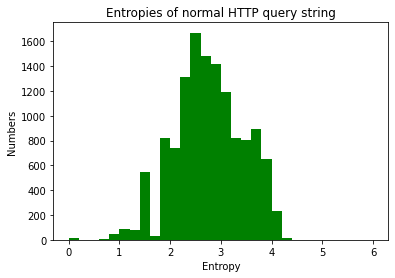

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# グラフのタイトルとラベルの設定
ax.set_title('Entropies of normal HTTP query string')
ax.set_xlabel('Entropy')
ax.set_ylabel('Numbers')

# 度数分布グラフの描画
plt.hist(norm_entropies, bins=30, range=(0,6), color='green')
plt.show()

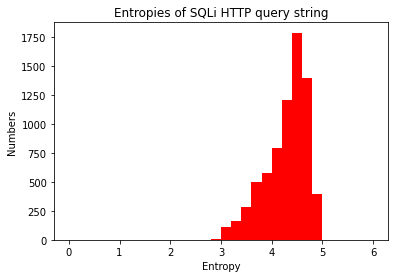

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# グラフのタイトルとラベルの設定
ax.set_title('Entropies of SQLi HTTP query string')
ax.set_xlabel('Entropy')
ax.set_ylabel('Numbers')

# 度数分布グラフの描画
plt.hist(sqli_entropies, bins=30, range=(0,6), color='red')
plt.show()

In [ ]:
df_sqli = df[df.attack_type == 'sqli']
df_sqli

payload  ...  label
291    1' where 6406=6406;select count(*) from rdb$fi...  ...   anom
292    1) and 8514=(select count(*) from domain.domai...  ...   anom
293                      1) where 7956=7956 or sleep(5)#  ...   anom
294                               -7387'))) order by 1--  ...   anom
295                1))) union all select null,null,null#  ...   anom
...                                                  ...  ...    ...
20360          1%")) and elt(4249=4249,7259) and (("%"="  ...   anom
20361  -7773' or 5903=('qqpjq'||(select case 5903 whe...  ...   anom
20362                                    1" order by 1--  ...   anom
20363  1' procedure analyse(extractvalue(5840,concat(...  ...   anom
20364  -7511)) as xqzf where 9939=9939 union all sele...  ...   anom

[7235 rows x 4 columns]

In [ ]:
print('{:.2%}'.format(
    df_sqli['payload'].str.contains('\)').sum() \
    / len(df_sqli['payload'])
    )
)

90.91%


In [ ]:
df_norm = df[df.attack_type == 'norm']
print('{:.2%}'.format(
    df_norm['payload'].str.contains('\)').sum() \
    / len(df_norm['payload'])
    )
)

0.01%


In [ ]:
def func_preprocessing(df):
    train_rows = ((df.attack_type == 'norm') | (df.attack_type == 'sqli'))
    df = df[train_rows]

    # エントロピーと閉じ括弧の有無を入れる配列
    entropies = []
    closing_parenthesis = []
    
    # payload列からHTTPクエリストリングを取り出して処理させる
    for i in df['payload']:
        # エントロピーの計算と代入
        entropies.append(H_entropy(i))
        
        # 閉じ括弧を検出して、存在した場合は列closing_parenthesisに1を設定、
        # ない場合は0を設定
        if i.count(')'):
            closing_parenthesis.append(1)
        else:
            closing_parenthesis.append(0)
    
    # データセットに新たに列を追加
    df = df.assign(entropy=entropies)
    df = df.assign(closing_parenthesis=closing_parenthesis)
    
    # データセットのlabel列のnormを0に、anormを1に変更
    rep = df.label.replace({"norm":0,"anom":1})
    df = df.assign(label=rep)
    
    return df

In [ ]:
df = func_preprocessing(df)

In [ ]:
df

payload  ...  closing_parenthesis
0                                         c/ caridad s/n  ...                    0
1                                           campello, el  ...                    0
2                                       1442431887503330  ...                    0
3                                                  nue37  ...                    0
4                                         tufts3@joll.rs  ...                    0
...                                                  ...  ...                  ...
20360          1%")) and elt(4249=4249,7259) and (("%"="  ...                    1
20361  -7773' or 5903=('qqpjq'||(select case 5903 whe...  ...                    1
20362                                    1" order by 1--  ...                    0
20363  1' procedure analyse(extractvalue(5840,concat(...  ...                    1
20364  -7511)) as xqzf where 9939=9939 union all sele...  ...                    1

[20105 rows x 6 columns]

In [ ]:
# 交差検証を行うため、テスト用に分割されているデータも読み込んで単一の行列にする
# テストデータのロード
test_data = pd.read_csv('./HttpParamsDataset/payload_test.csv')
test_data = func_preprocessing(test_data)

# 特徴量に使用する列のみを抽出
df_x = df[['length','entropy','closing_parenthesis']]
test_x = test_data[['length','entropy','closing_parenthesis']]

# ラベルのみを抽出
df_y = df[['label']]
test_y = test_data[['label']]

# 特徴量とラベルとして、それぞれひとつにまとめる
X_all = pd.concat([df_x, test_x])
y_all = pd.concat([df_y, test_y])

In [ ]:
X_all

length   entropy  closing_parenthesis
0          14  3.093069                    0
1          12  3.022055                    0
2          16  2.827820                    0
3           5  2.321928                    0
4          14  3.378783                    0
...       ...       ...                  ...
10176     113  4.422041                    1
10177     113  4.514233                    1
10178     136  4.630369                    1
10179     111  4.539371                    1
10180      53  4.130354                    1

[30156 rows x 3 columns]

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import train_test_split
import numpy as np
import optuna
from sklearn.model_selection import cross_validate

# データセットを訓練用とテスト用に分割
X_train, X_test, y_train, y_test = \
train_test_split(X_all, y_all, test_size=0.2, shuffle=True, random_state=101)

class Objective_DTC:
    def __init__(self, X, y):
        # 変数 X,y の初期化
        self.X = X
        self.y = y

    def __call__(self, trial):
        # チューニング対象のハイパーパラメータの設定
        params ={
        'criterion': trial.suggest_categorical(
            'criterion', 
            ['gini', 'entropy']
            ),
        'max_depth': trial.suggest_int(
            'max_depth', 
            1, 64
            )
        }
        model = DecisionTreeClassifier(**params)

        scores = cross_validate(model,
                                X=self.X, y=self.y,
                                scoring='accuracy',
                                n_jobs=-1)
        # 交差検証結果の平均を戻り値に設定
        return scores['test_score'].mean()

objective = Objective_DTC(X_train, y_train)
study = optuna.create_study()
study.optimize(objective, timeout=60)
print('params:', study.best_params)

[I 2021-10-02 10:04:32,734] A new study created in memory with name: no-name-2c014d70-5d8f-49a6-b380-8e142e7b53f5
[I 2021-10-02 10:04:34,146] Trial 0 finished with value: 0.9840408664793477 and parameters: {'criterion': 'entropy', 'max_depth': 3}. Best is trial 0 with value: 0.9840408664793477.
[I 2021-10-02 10:04:34,266] Trial 1 finished with value: 0.9804344770104573 and parameters: {'criterion': 'gini', 'max_depth': 36}. Best is trial 1 with value: 0.9804344770104573.
[I 2021-10-02 10:04:34,387] Trial 2 finished with value: 0.9801028192371476 and parameters: {'criterion': 'gini', 'max_depth': 47}. Best is trial 2 with value: 0.9801028192371476.
[I 2021-10-02 10:04:34,505] Trial 3 finished with value: 0.9801857379767827 and parameters: {'criterion': 'gini', 'max_depth': 29}. Best is trial 2 with value: 0.9801028192371476.
[I 2021-10-02 10:04:34,631] Trial 4 finished with value: 0.9798955653511372 and parameters: {'criterion': 'entropy', 'max_depth': 49}. Best is trial 4 with value: 0

params: {'criterion': 'entropy', 'max_depth': 1}


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# 訓練の実施
model = DecisionTreeClassifier(
    criterion = study.best_params['criterion'],
    max_depth = study.best_params['max_depth']
)
model.fit(X_train, y_train)
pred = model.predict(X_test)

# 正解率と混同行列の出力
print("Accuracy: {:.5f} %".format(100 * accuracy_score(y_test, pred)))
print(confusion_matrix(y_test, pred))

Accuracy: 96.71751 %
[[3847    0]
 [ 198 1987]]


In [ ]:
import pandas as pd

# データセットを再ロードする
df = pd.read_csv('./HttpParamsDataset/payload_train.csv')
test_data = pd.read_csv('./HttpParamsDataset/payload_test.csv')

train_rows = ((df.attack_type == 'norm') | (df.attack_type == 'sqli'))
df = df[train_rows]

test_train_rows = ((test_data.attack_type == 'norm') | (test_data.attack_type == 'sqli'))
test_data = test_data[test_train_rows]

df_y = df[['label']]
test_y = test_data[['label']]

df_x = df.iloc[:,:-1]
test_x = test_data.iloc[:,:-1]

X_all = pd.concat([df_x, test_x])
y_all = pd.concat([df_y, test_y])

rep = y_all.label.replace({"norm":0,"anom":1})
y_all = y_all.assign(label=rep)

In [ ]:
X_all

payload  length attack_type
0                                         c/ caridad s/n      14        norm
1                                           campello, el      12        norm
2                                       1442431887503330      16        norm
3                                                  nue37       5        norm
4                                         tufts3@joll.rs      14        norm
...                                                  ...     ...         ...
10176  1") where 2367=2367;select (case when (4666=46...     113        sqli
10177  1') and updatexml(3393,concat(0x2e,0x7171706a7...     113        sqli
10178  1') as tqdg where 9355=9355;select (case when ...     136        sqli
10179  1') and extractvalue(7982,concat(0x5c,0x717170...     111        sqli
10180  1 rlike (select * from (select(sleep(5)))sgvo)...      53        sqli

[30156 rows x 3 columns]

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

X = X_all['payload']
y = y_all

# ベクトル化のためのオプションの設定、文字を対象にユニグラムを行う
vec_opts = {
    "ngram_range": (1, 1), 
    "analyzer": "char", 
    "min_df" : 0.1
}

# TfidfVectorizerの初期化
v = TfidfVectorizer(**vec_opts)
# ベクトル化の実行
X = v.fit_transform(X)

In [ ]:
import numpy as np

# 特徴に使用されている文字を出力
features = v.get_feature_names()
np.array(features)

array([' ', '"', "'", '(', ')', '*', ',', '-', '.', '0', '1', '2', '3',
       '4', '5', '6', '7', '8', '9', '=', 'a', 'b', 'c', 'd', 'e', 'f',
       'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u',
       'v', 'w', 'x', 'y'], dtype='<U1')

In [ ]:
df = pd.DataFrame(X.toarray())
df.columns = features
df

"         '  ...         w         x         y
0      0.453262  0.000000  0.000000  ...  0.000000  0.000000  0.000000
1      0.223881  0.000000  0.000000  ...  0.000000  0.000000  0.000000
2      0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000
3      0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000
4      0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000
...         ...       ...       ...  ...       ...       ...       ...
30151  0.427799  0.061067  0.000000  ...  0.100595  0.000000  0.056381
30152  0.166014  0.000000  0.208435  ...  0.000000  0.369485  0.000000
30153  0.468956  0.000000  0.049065  ...  0.095570  0.000000  0.000000
30154  0.171542  0.000000  0.215375  ...  0.000000  0.254525  0.000000
30155  0.401641  0.000000  0.000000  ...  0.000000  0.124153  0.000000

[30156 rows x 43 columns]

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
import optuna.integration.lightgbm as olgb
import optuna

# データセットを訓練用とテスト用に分割
X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.2, shuffle=True, random_state=101)

# LightGBM用のデータセットに変換
train = olgb.Dataset(X_train, y_train)

# パラメータの設定
params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "verbosity": -1,
    "boosting_type": "gbdt",
}

# 交差検証を使用したハイパーパラメータの探索
tuner = olgb.LightGBMTunerCV(params, train)

# ハイパーパラメータ探索の実行
tuner.run()

[I 2021-10-02 10:11:26,464] A new study created in memory with name: no-name-88e91495-1327-4216-9993-1ca78d549198
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

[1]	cv_agg's binary_logloss: 0.562929 + 0.000464451
[2]	cv_agg's binary_logloss: 0.4912 + 0.000647826
[3]	cv_agg's binary_logloss: 0.429744 + 0.000563485
[4]	cv_agg's binary_logloss: 0.377634 + 0.000504091
[5]	cv_agg's binary_logloss: 0.333806 + 0.000426492
[6]	cv_agg's binary_logloss: 0.296462 + 0.00037117
[7]	cv_agg's binary_logloss: 0.264749 + 0.00023532
[8]	cv_agg's binary_logloss: 0.235799 + 0.000234339
[9]	cv_agg's binary_logloss: 0.210742 + 0.000197119
[10]	cv_agg's binary_logloss: 0.19072 + 0.000189068
[11]	cv_agg's binary_logloss: 0.171522 + 0.000226694
[12]	cv_agg's binary_logloss: 0.154102 + 0.00025977
[13]	cv_agg's binary_logloss: 0.138728 + 0.000238062
[14]	cv_agg's binary_logloss: 0.125505 + 0.000242702
[15]	cv_agg's binary_logloss: 0.112982 + 0.00020379
[16]	cv_agg's binary_logloss: 0.10193 + 0.000194941
[17]	cv_agg's binary_logloss: 0.0919213 + 0.000163182
[18]	cv_agg's binary_logloss: 0.08301 + 0.000161547
[19]	cv_agg's binary_logloss: 0.0749166 + 0.000173948
[20]	cv_a

feature_fraction, val_score: 0.001367:  14%|#4        | 1/7 [00:16<01:36, 16.05s/it]

[1000]	cv_agg's binary_logloss: 0.00136735 + 0.00137961
[1]	cv_agg's binary_logloss: 0.561742 + 0.000315724
[2]	cv_agg's binary_logloss: 0.489854 + 0.00045469
[3]	cv_agg's binary_logloss: 0.428014 + 0.000421689
[4]	cv_agg's binary_logloss: 0.376145 + 0.000362313
[5]	cv_agg's binary_logloss: 0.332006 + 0.000282842
[6]	cv_agg's binary_logloss: 0.2946 + 0.000322179
[7]	cv_agg's binary_logloss: 0.26189 + 0.000254274
[8]	cv_agg's binary_logloss: 0.233289 + 0.000201029
[9]	cv_agg's binary_logloss: 0.208502 + 0.000160475
[10]	cv_agg's binary_logloss: 0.186622 + 0.000181613
[11]	cv_agg's binary_logloss: 0.168057 + 0.000125813
[12]	cv_agg's binary_logloss: 0.150778 + 0.000132769
[13]	cv_agg's binary_logloss: 0.135563 + 0.000140946
[14]	cv_agg's binary_logloss: 0.122681 + 0.000152235
[15]	cv_agg's binary_logloss: 0.110454 + 0.000144929
[16]	cv_agg's binary_logloss: 0.0996693 + 0.000204268
[17]	cv_agg's binary_logloss: 0.0898445 + 0.000215384
[18]	cv_agg's binary_logloss: 0.0811486 + 0.000224924


feature_fraction, val_score: 0.001364:  29%|##8       | 2/7 [00:30<01:16, 15.34s/it]


[993]	cv_agg's binary_logloss: 0.00136397 + 0.00137426
[994]	cv_agg's binary_logloss: 0.00136389 + 0.00137442
[995]	cv_agg's binary_logloss: 0.00136394 + 0.0013743
[996]	cv_agg's binary_logloss: 0.00136392 + 0.00137433
[997]	cv_agg's binary_logloss: 0.00136406 + 0.00137467
[998]	cv_agg's binary_logloss: 0.00136423 + 0.00137489
[999]	cv_agg's binary_logloss: 0.00136375 + 0.00137476
[1000]	cv_agg's binary_logloss: 0.00136416 + 0.00137478
[1]	cv_agg's binary_logloss: 0.558906 + 0.000190592
[2]	cv_agg's binary_logloss: 0.484117 + 0.000211867
[3]	cv_agg's binary_logloss: 0.423117 + 0.000282375
[4]	cv_agg's binary_logloss: 0.371977 + 0.000363541
[5]	cv_agg's binary_logloss: 0.32848 + 0.000392177
[6]	cv_agg's binary_logloss: 0.291112 + 0.00039094
[7]	cv_agg's binary_logloss: 0.259004 + 0.000400444
[8]	cv_agg's binary_logloss: 0.2309 + 0.000461332
[9]	cv_agg's binary_logloss: 0.206378 + 0.000444991
[10]	cv_agg's binary_logloss: 0.184747 + 0.000493216
[11]	cv_agg's binary_logloss: 0.165866 + 0

feature_fraction, val_score: 0.001364:  43%|####2     | 3/7 [00:49<01:06, 16.72s/it]

[996]	cv_agg's binary_logloss: 0.00170935 + 0.00165173
[997]	cv_agg's binary_logloss: 0.00170943 + 0.00165202
[998]	cv_agg's binary_logloss: 0.00170965 + 0.00165176
[999]	cv_agg's binary_logloss: 0.00170995 + 0.00165192
[1000]	cv_agg's binary_logloss: 0.0017097 + 0.00165179
[1]	cv_agg's binary_logloss: 0.558764 + 6.1971e-05
[2]	cv_agg's binary_logloss: 0.484062 + 0.000129218
[3]	cv_agg's binary_logloss: 0.422871 + 0.00016434
[4]	cv_agg's binary_logloss: 0.371684 + 0.000298464
[5]	cv_agg's binary_logloss: 0.328288 + 0.000366428
[6]	cv_agg's binary_logloss: 0.29107 + 0.000458548
[7]	cv_agg's binary_logloss: 0.258884 + 0.000565966
[8]	cv_agg's binary_logloss: 0.230882 + 0.000624182
[9]	cv_agg's binary_logloss: 0.206357 + 0.000680645
[10]	cv_agg's binary_logloss: 0.184822 + 0.000763787
[11]	cv_agg's binary_logloss: 0.165765 + 0.000810717
[12]	cv_agg's binary_logloss: 0.148876 + 0.000850003
[13]	cv_agg's binary_logloss: 0.133913 + 0.00085699
[14]	cv_agg's binary_logloss: 0.120566 + 0.000879

feature_fraction, val_score: 0.001364:  57%|#####7    | 4/7 [01:10<00:55, 18.34s/it]

[997]	cv_agg's binary_logloss: 0.00219758 + 0.00198339
[998]	cv_agg's binary_logloss: 0.00219775 + 0.00198384
[999]	cv_agg's binary_logloss: 0.00219794 + 0.00198366
[1000]	cv_agg's binary_logloss: 0.00219752 + 0.00198365
[1]	cv_agg's binary_logloss: 0.559044 + 0.0001743
[2]	cv_agg's binary_logloss: 0.484233 + 0.000175379
[3]	cv_agg's binary_logloss: 0.422988 + 0.000228547
[4]	cv_agg's binary_logloss: 0.371818 + 0.000268155
[5]	cv_agg's binary_logloss: 0.328334 + 0.000279798
[6]	cv_agg's binary_logloss: 0.291009 + 0.000383531
[7]	cv_agg's binary_logloss: 0.258932 + 0.000401085
[8]	cv_agg's binary_logloss: 0.230844 + 0.000519618
[9]	cv_agg's binary_logloss: 0.2062 + 0.000580214
[10]	cv_agg's binary_logloss: 0.184584 + 0.000619138
[11]	cv_agg's binary_logloss: 0.165752 + 0.000613141
[12]	cv_agg's binary_logloss: 0.148755 + 0.000604644
[13]	cv_agg's binary_logloss: 0.13375 + 0.000663421
[14]	cv_agg's binary_logloss: 0.120377 + 0.000664877
[15]	cv_agg's binary_logloss: 0.108429 + 0.00069145

feature_fraction, val_score: 0.001364:  71%|#######1  | 5/7 [01:29<00:37, 18.78s/it]

[995]	cv_agg's binary_logloss: 0.0019951 + 0.00190831
[996]	cv_agg's binary_logloss: 0.00199546 + 0.00190869
[997]	cv_agg's binary_logloss: 0.00199536 + 0.00190818
[998]	cv_agg's binary_logloss: 0.00199581 + 0.00190842
[999]	cv_agg's binary_logloss: 0.00199529 + 0.00190815
[1000]	cv_agg's binary_logloss: 0.0019955 + 0.00190828
[1]	cv_agg's binary_logloss: 0.559637 + 0.000244525
[2]	cv_agg's binary_logloss: 0.484667 + 0.000247044
[3]	cv_agg's binary_logloss: 0.423633 + 0.00023422
[4]	cv_agg's binary_logloss: 0.372506 + 0.000218595
[5]	cv_agg's binary_logloss: 0.328868 + 0.000212822
[6]	cv_agg's binary_logloss: 0.29146 + 0.000254219
[7]	cv_agg's binary_logloss: 0.259355 + 0.000265412
[8]	cv_agg's binary_logloss: 0.231054 + 0.000253789
[9]	cv_agg's binary_logloss: 0.206518 + 0.000255882
[10]	cv_agg's binary_logloss: 0.184819 + 0.000293029
[11]	cv_agg's binary_logloss: 0.165808 + 0.000280084
[12]	cv_agg's binary_logloss: 0.148816 + 0.000301021
[13]	cv_agg's binary_logloss: 0.133726 + 0.000

feature_fraction, val_score: 0.001364:  86%|########5 | 6/7 [01:47<00:18, 18.34s/it]

[997]	cv_agg's binary_logloss: 0.0017455 + 0.001569
[998]	cv_agg's binary_logloss: 0.00174561 + 0.00156902
[999]	cv_agg's binary_logloss: 0.00174546 + 0.00156899
[1000]	cv_agg's binary_logloss: 0.0017451 + 0.00156888
[1]	cv_agg's binary_logloss: 0.559652 + 0.000259438
[2]	cv_agg's binary_logloss: 0.484816 + 0.000316881
[3]	cv_agg's binary_logloss: 0.423801 + 0.000343005
[4]	cv_agg's binary_logloss: 0.372654 + 0.000307541
[5]	cv_agg's binary_logloss: 0.328966 + 0.000296769
[6]	cv_agg's binary_logloss: 0.29195 + 0.000308376
[7]	cv_agg's binary_logloss: 0.259662 + 0.000346908
[8]	cv_agg's binary_logloss: 0.231342 + 0.000333907
[9]	cv_agg's binary_logloss: 0.206794 + 0.000340347
[10]	cv_agg's binary_logloss: 0.185103 + 0.000372965
[11]	cv_agg's binary_logloss: 0.166076 + 0.00036346
[12]	cv_agg's binary_logloss: 0.149046 + 0.000369995
[13]	cv_agg's binary_logloss: 0.134058 + 0.00035916
[14]	cv_agg's binary_logloss: 0.121173 + 0.000391076
[15]	cv_agg's binary_logloss: 0.109086 + 0.000387433


feature_fraction, val_score: 0.001364: 100%|##########| 7/7 [02:03<00:00, 17.62s/it]



[996]	cv_agg's binary_logloss: 0.00147914 + 0.00139714
[997]	cv_agg's binary_logloss: 0.00147903 + 0.00139676
[998]	cv_agg's binary_logloss: 0.00147889 + 0.00139708
[999]	cv_agg's binary_logloss: 0.00147838 + 0.0013971
[1000]	cv_agg's binary_logloss: 0.00147901 + 0.00139716


num_leaves, val_score: 0.001364:   0%|          | 0/20 [00:00<?, ?it/s]

[1]	cv_agg's binary_logloss: 0.561375 + 0.00046669
[2]	cv_agg's binary_logloss: 0.488824 + 0.00073315
[3]	cv_agg's binary_logloss: 0.427217 + 0.000692076
[4]	cv_agg's binary_logloss: 0.375494 + 0.000543573
[5]	cv_agg's binary_logloss: 0.331472 + 0.000425257
[6]	cv_agg's binary_logloss: 0.294151 + 0.000366159
[7]	cv_agg's binary_logloss: 0.261519 + 0.000289408
[8]	cv_agg's binary_logloss: 0.23299 + 0.000197525
[9]	cv_agg's binary_logloss: 0.208247 + 0.000172943
[10]	cv_agg's binary_logloss: 0.186406 + 0.000163874
[11]	cv_agg's binary_logloss: 0.167717 + 0.000142888
[12]	cv_agg's binary_logloss: 0.150486 + 0.000132041
[13]	cv_agg's binary_logloss: 0.13529 + 0.000122109
[14]	cv_agg's binary_logloss: 0.122309 + 0.000133746
[15]	cv_agg's binary_logloss: 0.110119 + 0.000146753
[16]	cv_agg's binary_logloss: 0.0993504 + 0.000187124
[17]	cv_agg's binary_logloss: 0.0895543 + 0.000207052
[18]	cv_agg's binary_logloss: 0.0808834 + 0.000211187
[19]	cv_agg's binary_logloss: 0.0730193 + 0.000228554
[2

num_leaves, val_score: 0.001287:   5%|5         | 1/20 [00:20<06:34, 20.78s/it]

[1]	cv_agg's binary_logloss: 0.561374 + 0.000466176
[2]	cv_agg's binary_logloss: 0.488814 + 0.000728094
[3]	cv_agg's binary_logloss: 0.42721 + 0.00069143
[4]	cv_agg's binary_logloss: 0.375482 + 0.000546736
[5]	cv_agg's binary_logloss: 0.331458 + 0.000429701
[6]	cv_agg's binary_logloss: 0.294142 + 0.000366621
[7]	cv_agg's binary_logloss: 0.26151 + 0.000287819
[8]	cv_agg's binary_logloss: 0.232982 + 0.000191991
[9]	cv_agg's binary_logloss: 0.20824 + 0.00016472
[10]	cv_agg's binary_logloss: 0.1864 + 0.000149725
[11]	cv_agg's binary_logloss: 0.167718 + 0.000133984
[12]	cv_agg's binary_logloss: 0.150487 + 0.000120335
[13]	cv_agg's binary_logloss: 0.135295 + 0.000115633
[14]	cv_agg's binary_logloss: 0.122308 + 0.000113688
[15]	cv_agg's binary_logloss: 0.110118 + 0.000126924
[16]	cv_agg's binary_logloss: 0.0993495 + 0.000170045
[17]	cv_agg's binary_logloss: 0.0895535 + 0.000190896
[18]	cv_agg's binary_logloss: 0.0808849 + 0.000195931
[19]	cv_agg's binary_logloss: 0.0730231 + 0.000219623
[20]	

num_leaves, val_score: 0.001287:  10%|#         | 2/20 [00:38<05:46, 19.26s/it]

[997]	cv_agg's binary_logloss: 0.00129836 + 0.00130254
[998]	cv_agg's binary_logloss: 0.0012985 + 0.0013022
[999]	cv_agg's binary_logloss: 0.00129829 + 0.00130216
[1000]	cv_agg's binary_logloss: 0.00129885 + 0.00130234
[1]	cv_agg's binary_logloss: 0.561375 + 0.00046669
[2]	cv_agg's binary_logloss: 0.488821 + 0.000733795
[3]	cv_agg's binary_logloss: 0.427215 + 0.0006893
[4]	cv_agg's binary_logloss: 0.375494 + 0.000540039
[5]	cv_agg's binary_logloss: 0.331473 + 0.000421564
[6]	cv_agg's binary_logloss: 0.294153 + 0.000363871
[7]	cv_agg's binary_logloss: 0.261523 + 0.000287138
[8]	cv_agg's binary_logloss: 0.232994 + 0.000195593
[9]	cv_agg's binary_logloss: 0.208237 + 0.000166584
[10]	cv_agg's binary_logloss: 0.186398 + 0.000166525
[11]	cv_agg's binary_logloss: 0.167707 + 0.000141785
[12]	cv_agg's binary_logloss: 0.150477 + 0.000132976
[13]	cv_agg's binary_logloss: 0.135282 + 0.000125622
[14]	cv_agg's binary_logloss: 0.1223 + 0.000141641
[15]	cv_agg's binary_logloss: 0.110111 + 0.000151963


num_leaves, val_score: 0.001287:  15%|#5        | 3/20 [01:03<06:10, 21.81s/it]

[1]	cv_agg's binary_logloss: 0.561508 + 0.000383343
[2]	cv_agg's binary_logloss: 0.489236 + 0.000549506
[3]	cv_agg's binary_logloss: 0.427526 + 0.000514208
[4]	cv_agg's binary_logloss: 0.375722 + 0.000430101
[5]	cv_agg's binary_logloss: 0.33168 + 0.000361648
[6]	cv_agg's binary_logloss: 0.294351 + 0.000396844
[7]	cv_agg's binary_logloss: 0.261689 + 0.000330903
[8]	cv_agg's binary_logloss: 0.233134 + 0.000254293
[9]	cv_agg's binary_logloss: 0.208375 + 0.000227464
[10]	cv_agg's binary_logloss: 0.186508 + 0.000233362
[11]	cv_agg's binary_logloss: 0.167886 + 0.0001792
[12]	cv_agg's binary_logloss: 0.150628 + 0.000170208
[13]	cv_agg's binary_logloss: 0.135419 + 0.000178878
[14]	cv_agg's binary_logloss: 0.122507 + 0.000175567
[15]	cv_agg's binary_logloss: 0.110297 + 0.000173076
[16]	cv_agg's binary_logloss: 0.0995215 + 0.00021502
[17]	cv_agg's binary_logloss: 0.0897095 + 0.000222326
[18]	cv_agg's binary_logloss: 0.0810212 + 0.00022008
[19]	cv_agg's binary_logloss: 0.0731485 + 0.000232676
[20

num_leaves, val_score: 0.001287:  20%|##        | 4/20 [01:19<05:09, 19.37s/it]

[998]	cv_agg's binary_logloss: 0.00134464 + 0.00134937
[999]	cv_agg's binary_logloss: 0.00134484 + 0.00134947
[1000]	cv_agg's binary_logloss: 0.00134472 + 0.00134954
[1]	cv_agg's binary_logloss: 0.562063 + 0.00040295
[2]	cv_agg's binary_logloss: 0.490271 + 0.000629527
[3]	cv_agg's binary_logloss: 0.428363 + 0.00057157
[4]	cv_agg's binary_logloss: 0.376428 + 0.000484182
[5]	cv_agg's binary_logloss: 0.332247 + 0.000395813
[6]	cv_agg's binary_logloss: 0.294851 + 0.000451744
[7]	cv_agg's binary_logloss: 0.262123 + 0.000389311
[8]	cv_agg's binary_logloss: 0.233501 + 0.000305631
[9]	cv_agg's binary_logloss: 0.208701 + 0.000241672
[10]	cv_agg's binary_logloss: 0.186799 + 0.000239249
[11]	cv_agg's binary_logloss: 0.168308 + 0.000174366
[12]	cv_agg's binary_logloss: 0.151003 + 0.000164609
[13]	cv_agg's binary_logloss: 0.135781 + 0.000179722
[14]	cv_agg's binary_logloss: 0.122911 + 0.000153005
[15]	cv_agg's binary_logloss: 0.110658 + 0.000136479
[16]	cv_agg's binary_logloss: 0.0998654 + 0.000193

num_leaves, val_score: 0.001287:  25%|##5       | 5/20 [01:34<04:27, 17.85s/it]

[985]	cv_agg's binary_logloss: 0.00138714 + 0.0013759
[986]	cv_agg's binary_logloss: 0.00138697 + 0.0013754
[987]	cv_agg's binary_logloss: 0.00138692 + 0.00137555
[988]	cv_agg's binary_logloss: 0.00138674 + 0.00137559
[989]	cv_agg's binary_logloss: 0.00138718 + 0.00137608
[990]	cv_agg's binary_logloss: 0.00138732 + 0.00137612
[991]	cv_agg's binary_logloss: 0.00138749 + 0.00137608
[992]	cv_agg's binary_logloss: 0.00138728 + 0.00137565
[993]	cv_agg's binary_logloss: 0.00138672 + 0.00137559
[994]	cv_agg's binary_logloss: 0.00138703 + 0.0013756
[995]	cv_agg's binary_logloss: 0.00138706 + 0.00137594
[996]	cv_agg's binary_logloss: 0.00138749 + 0.00137603
[997]	cv_agg's binary_logloss: 0.00138773 + 0.0013764
[998]	cv_agg's binary_logloss: 0.00138795 + 0.00137633
[999]	cv_agg's binary_logloss: 0.00138795 + 0.00137646
[1000]	cv_agg's binary_logloss: 0.00138777 + 0.00137642
[1]	cv_agg's binary_logloss: 0.561375 + 0.00046669
[2]	cv_agg's binary_logloss: 0.488821 + 0.000733546
[3]	cv_agg's binary_

num_leaves, val_score: 0.001287:  30%|###       | 6/20 [01:57<04:34, 19.57s/it]

[994]	cv_agg's binary_logloss: 0.00130841 + 0.00133532
[995]	cv_agg's binary_logloss: 0.00130865 + 0.00133527
[996]	cv_agg's binary_logloss: 0.00130838 + 0.00133531
[997]	cv_agg's binary_logloss: 0.0013084 + 0.00133496
[998]	cv_agg's binary_logloss: 0.0013085 + 0.00133508
[999]	cv_agg's binary_logloss: 0.00130881 + 0.00133514
[1000]	cv_agg's binary_logloss: 0.00130852 + 0.00133512
[1]	cv_agg's binary_logloss: 0.561418 + 0.000446076
[2]	cv_agg's binary_logloss: 0.48906 + 0.000652435
[3]	cv_agg's binary_logloss: 0.427405 + 0.000592931
[4]	cv_agg's binary_logloss: 0.375631 + 0.00047505
[5]	cv_agg's binary_logloss: 0.331609 + 0.000385649
[6]	cv_agg's binary_logloss: 0.294272 + 0.00039338
[7]	cv_agg's binary_logloss: 0.261626 + 0.000310123
[8]	cv_agg's binary_logloss: 0.233079 + 0.000229293
[9]	cv_agg's binary_logloss: 0.208328 + 0.000193151
[10]	cv_agg's binary_logloss: 0.186478 + 0.000176483
[11]	cv_agg's binary_logloss: 0.167752 + 0.000167984
[12]	cv_agg's binary_logloss: 0.150511 + 0.00

num_leaves, val_score: 0.001287:  35%|###5      | 7/20 [02:13<04:00, 18.49s/it]


[989]	cv_agg's binary_logloss: 0.00129042 + 0.0013513
[990]	cv_agg's binary_logloss: 0.00129046 + 0.00135138
[991]	cv_agg's binary_logloss: 0.00129043 + 0.00135132
[992]	cv_agg's binary_logloss: 0.00129052 + 0.00135133
[993]	cv_agg's binary_logloss: 0.00129036 + 0.00135145
[994]	cv_agg's binary_logloss: 0.00129038 + 0.00135144
[995]	cv_agg's binary_logloss: 0.0012908 + 0.0013519
[996]	cv_agg's binary_logloss: 0.0012908 + 0.00135196
[997]	cv_agg's binary_logloss: 0.00129076 + 0.00135191
[998]	cv_agg's binary_logloss: 0.00129079 + 0.00135202
[999]	cv_agg's binary_logloss: 0.00129064 + 0.00135211
[1000]	cv_agg's binary_logloss: 0.00129084 + 0.00135208
[1]	cv_agg's binary_logloss: 0.561375 + 0.00046669
[2]	cv_agg's binary_logloss: 0.488822 + 0.000733761
[3]	cv_agg's binary_logloss: 0.427215 + 0.000689276
[4]	cv_agg's binary_logloss: 0.375495 + 0.000540181
[5]	cv_agg's binary_logloss: 0.331474 + 0.000421791
[6]	cv_agg's binary_logloss: 0.294155 + 0.000364587
[7]	cv_agg's binary_logloss: 0.

num_leaves, val_score: 0.001287:  40%|####      | 8/20 [02:38<04:05, 20.45s/it]

[987]	cv_agg's binary_logloss: 0.00131461 + 0.00133419
[988]	cv_agg's binary_logloss: 0.00131483 + 0.00133409
[989]	cv_agg's binary_logloss: 0.001315 + 0.00133455
[990]	cv_agg's binary_logloss: 0.00131457 + 0.0013341
[991]	cv_agg's binary_logloss: 0.00131481 + 0.00133453
[992]	cv_agg's binary_logloss: 0.00131449 + 0.00133414
[993]	cv_agg's binary_logloss: 0.00131418 + 0.00133402
[994]	cv_agg's binary_logloss: 0.00131431 + 0.00133409
[995]	cv_agg's binary_logloss: 0.0013143 + 0.00133411
[996]	cv_agg's binary_logloss: 0.00131426 + 0.00133401
[997]	cv_agg's binary_logloss: 0.00131451 + 0.00133443
[998]	cv_agg's binary_logloss: 0.00131407 + 0.00133403
[999]	cv_agg's binary_logloss: 0.00131414 + 0.00133418
[1000]	cv_agg's binary_logloss: 0.00131411 + 0.00133408
[1]	cv_agg's binary_logloss: 0.561375 + 0.00046669
[2]	cv_agg's binary_logloss: 0.488821 + 0.000733799
[3]	cv_agg's binary_logloss: 0.427214 + 0.000688965
[4]	cv_agg's binary_logloss: 0.375493 + 0.000541376
[5]	cv_agg's binary_loglos

num_leaves, val_score: 0.001287:  45%|####5     | 9/20 [03:06<04:09, 22.68s/it]

[1]	cv_agg's binary_logloss: 0.561375 + 0.00046669
[2]	cv_agg's binary_logloss: 0.488821 + 0.000733792
[3]	cv_agg's binary_logloss: 0.427214 + 0.000688889
[4]	cv_agg's binary_logloss: 0.375493 + 0.00054126
[5]	cv_agg's binary_logloss: 0.331473 + 0.00042343
[6]	cv_agg's binary_logloss: 0.294152 + 0.000365815
[7]	cv_agg's binary_logloss: 0.261522 + 0.000288451
[8]	cv_agg's binary_logloss: 0.232993 + 0.000197234
[9]	cv_agg's binary_logloss: 0.208235 + 0.000169229
[10]	cv_agg's binary_logloss: 0.186396 + 0.000169456
[11]	cv_agg's binary_logloss: 0.167706 + 0.000144337
[12]	cv_agg's binary_logloss: 0.150476 + 0.000135601
[13]	cv_agg's binary_logloss: 0.135281 + 0.000128128
[14]	cv_agg's binary_logloss: 0.1223 + 0.000143684
[15]	cv_agg's binary_logloss: 0.110112 + 0.000153513
[16]	cv_agg's binary_logloss: 0.099345 + 0.000194939
[17]	cv_agg's binary_logloss: 0.0895497 + 0.000212862
[18]	cv_agg's binary_logloss: 0.0808794 + 0.000217668
[19]	cv_agg's binary_logloss: 0.073016 + 0.000234649
[20]	

num_leaves, val_score: 0.001287:  50%|#####     | 10/20 [03:33<04:02, 24.22s/it]

[996]	cv_agg's binary_logloss: 0.00132253 + 0.00136132
[997]	cv_agg's binary_logloss: 0.00132275 + 0.00136147
[998]	cv_agg's binary_logloss: 0.00132273 + 0.00136114
[999]	cv_agg's binary_logloss: 0.00132293 + 0.00136119
[1000]	cv_agg's binary_logloss: 0.00132273 + 0.00136117
[1]	cv_agg's binary_logloss: 0.561375 + 0.00046669
[2]	cv_agg's binary_logloss: 0.488824 + 0.000731348
[3]	cv_agg's binary_logloss: 0.427216 + 0.000691397
[4]	cv_agg's binary_logloss: 0.375493 + 0.000545314
[5]	cv_agg's binary_logloss: 0.331469 + 0.000428065
[6]	cv_agg's binary_logloss: 0.294153 + 0.000368044
[7]	cv_agg's binary_logloss: 0.261521 + 0.000288717
[8]	cv_agg's binary_logloss: 0.232992 + 0.000195295
[9]	cv_agg's binary_logloss: 0.208249 + 0.000169737
[10]	cv_agg's binary_logloss: 0.186407 + 0.000158604
[11]	cv_agg's binary_logloss: 0.167716 + 0.000138639
[12]	cv_agg's binary_logloss: 0.150484 + 0.000127426
[13]	cv_agg's binary_logloss: 0.135289 + 0.000121183
[14]	cv_agg's binary_logloss: 0.122305 + 0.00

num_leaves, val_score: 0.001287:  55%|#####5    | 11/20 [03:53<03:26, 22.92s/it]

[997]	cv_agg's binary_logloss: 0.00134135 + 0.0013379
[998]	cv_agg's binary_logloss: 0.00134154 + 0.00133792
[999]	cv_agg's binary_logloss: 0.0013418 + 0.00133783
[1000]	cv_agg's binary_logloss: 0.00134155 + 0.00133781
[1]	cv_agg's binary_logloss: 0.561375 + 0.00046669
[2]	cv_agg's binary_logloss: 0.488824 + 0.000733553
[3]	cv_agg's binary_logloss: 0.427217 + 0.000692244
[4]	cv_agg's binary_logloss: 0.375494 + 0.000544988
[5]	cv_agg's binary_logloss: 0.33147 + 0.000427908
[6]	cv_agg's binary_logloss: 0.29415 + 0.00036778
[7]	cv_agg's binary_logloss: 0.261517 + 0.00028891
[8]	cv_agg's binary_logloss: 0.232989 + 0.000197538
[9]	cv_agg's binary_logloss: 0.208246 + 0.000171301
[10]	cv_agg's binary_logloss: 0.186404 + 0.000160367
[11]	cv_agg's binary_logloss: 0.167716 + 0.000141444
[12]	cv_agg's binary_logloss: 0.150485 + 0.000130132
[13]	cv_agg's binary_logloss: 0.135289 + 0.000120711
[14]	cv_agg's binary_logloss: 0.122309 + 0.000131612
[15]	cv_agg's binary_logloss: 0.110119 + 0.000145057


num_leaves, val_score: 0.001273:  60%|######    | 12/20 [04:14<02:58, 22.37s/it]

[994]	cv_agg's binary_logloss: 0.00127237 + 0.00131245
[995]	cv_agg's binary_logloss: 0.00127228 + 0.00131252
[996]	cv_agg's binary_logloss: 0.00127243 + 0.00131247
[997]	cv_agg's binary_logloss: 0.00127269 + 0.00131287
[998]	cv_agg's binary_logloss: 0.00127268 + 0.00131242
[999]	cv_agg's binary_logloss: 0.00127308 + 0.00131242
[1000]	cv_agg's binary_logloss: 0.00127261 + 0.00131238
[1]	cv_agg's binary_logloss: 0.561375 + 0.00046669
[2]	cv_agg's binary_logloss: 0.488824 + 0.000732596
[3]	cv_agg's binary_logloss: 0.427216 + 0.0006909
[4]	cv_agg's binary_logloss: 0.375494 + 0.000542566
[5]	cv_agg's binary_logloss: 0.331471 + 0.000424441
[6]	cv_agg's binary_logloss: 0.29415 + 0.000365446
[7]	cv_agg's binary_logloss: 0.261519 + 0.000288972
[8]	cv_agg's binary_logloss: 0.232989 + 0.000197107
[9]	cv_agg's binary_logloss: 0.208246 + 0.000172396
[10]	cv_agg's binary_logloss: 0.186406 + 0.000164143
[11]	cv_agg's binary_logloss: 0.167717 + 0.000141792
[12]	cv_agg's binary_logloss: 0.150485 + 0.0

num_leaves, val_score: 0.001273:  65%|######5   | 13/20 [04:36<02:35, 22.16s/it]


[993]	cv_agg's binary_logloss: 0.00127518 + 0.00131908
[994]	cv_agg's binary_logloss: 0.00127486 + 0.00131923
[995]	cv_agg's binary_logloss: 0.00127491 + 0.00131912
[996]	cv_agg's binary_logloss: 0.00127498 + 0.00131907
[997]	cv_agg's binary_logloss: 0.00127514 + 0.00131958
[998]	cv_agg's binary_logloss: 0.00127547 + 0.00131967
[999]	cv_agg's binary_logloss: 0.00127505 + 0.00131964
[1000]	cv_agg's binary_logloss: 0.00127526 + 0.00131971
[1]	cv_agg's binary_logloss: 0.561375 + 0.00046669
[2]	cv_agg's binary_logloss: 0.488822 + 0.000733212
[3]	cv_agg's binary_logloss: 0.427214 + 0.000689927
[4]	cv_agg's binary_logloss: 0.375494 + 0.000541715
[5]	cv_agg's binary_logloss: 0.331472 + 0.000424296
[6]	cv_agg's binary_logloss: 0.294153 + 0.000366812
[7]	cv_agg's binary_logloss: 0.261522 + 0.000291307
[8]	cv_agg's binary_logloss: 0.232992 + 0.000199035
[9]	cv_agg's binary_logloss: 0.208236 + 0.00017081
[10]	cv_agg's binary_logloss: 0.186396 + 0.000170621
[11]	cv_agg's binary_logloss: 0.167707 

num_leaves, val_score: 0.001273:  70%|#######   | 14/20 [04:59<02:15, 22.55s/it]

[993]	cv_agg's binary_logloss: 0.00130244 + 0.00133651
[994]	cv_agg's binary_logloss: 0.00130249 + 0.00133649
[995]	cv_agg's binary_logloss: 0.00130252 + 0.00133689
[996]	cv_agg's binary_logloss: 0.00130271 + 0.00133692
[997]	cv_agg's binary_logloss: 0.00130243 + 0.00133657
[998]	cv_agg's binary_logloss: 0.00130296 + 0.00133701
[999]	cv_agg's binary_logloss: 0.0013029 + 0.00133697
[1000]	cv_agg's binary_logloss: 0.00130271 + 0.00133697
[1]	cv_agg's binary_logloss: 0.561374 + 0.00046719
[2]	cv_agg's binary_logloss: 0.488823 + 0.000731595
[3]	cv_agg's binary_logloss: 0.427218 + 0.000693388
[4]	cv_agg's binary_logloss: 0.375494 + 0.000546951
[5]	cv_agg's binary_logloss: 0.33147 + 0.00042935
[6]	cv_agg's binary_logloss: 0.294154 + 0.00037207
[7]	cv_agg's binary_logloss: 0.261521 + 0.000294251
[8]	cv_agg's binary_logloss: 0.232991 + 0.000199009
[9]	cv_agg's binary_logloss: 0.208236 + 0.000169898
[10]	cv_agg's binary_logloss: 0.186397 + 0.000163859
[11]	cv_agg's binary_logloss: 0.167712 + 0.

num_leaves, val_score: 0.001273:  75%|#######5  | 15/20 [05:19<01:48, 21.71s/it]

[992]	cv_agg's binary_logloss: 0.00131568 + 0.0013482
[993]	cv_agg's binary_logloss: 0.00131549 + 0.00134831
[994]	cv_agg's binary_logloss: 0.00131542 + 0.00134821
[995]	cv_agg's binary_logloss: 0.00131553 + 0.0013483
[996]	cv_agg's binary_logloss: 0.00131552 + 0.00134821
[997]	cv_agg's binary_logloss: 0.00131552 + 0.00134832
[998]	cv_agg's binary_logloss: 0.00131518 + 0.00134826
[999]	cv_agg's binary_logloss: 0.00131493 + 0.00134815
[1000]	cv_agg's binary_logloss: 0.00131517 + 0.0013482
[1]	cv_agg's binary_logloss: 0.561375 + 0.00046669
[2]	cv_agg's binary_logloss: 0.488824 + 0.000733306
[3]	cv_agg's binary_logloss: 0.427217 + 0.000690627
[4]	cv_agg's binary_logloss: 0.375493 + 0.000544202
[5]	cv_agg's binary_logloss: 0.33147 + 0.000425953
[6]	cv_agg's binary_logloss: 0.294151 + 0.000367874
[7]	cv_agg's binary_logloss: 0.261521 + 0.000292195
[8]	cv_agg's binary_logloss: 0.232992 + 0.000199524
[9]	cv_agg's binary_logloss: 0.208248 + 0.000173569
[10]	cv_agg's binary_logloss: 0.186407 + 

num_leaves, val_score: 0.001273:  80%|########  | 16/20 [05:41<01:27, 21.77s/it]


[987]	cv_agg's binary_logloss: 0.00128835 + 0.00132718
[988]	cv_agg's binary_logloss: 0.00128807 + 0.00132707
[989]	cv_agg's binary_logloss: 0.00128843 + 0.00132719
[990]	cv_agg's binary_logloss: 0.00128797 + 0.00132674
[991]	cv_agg's binary_logloss: 0.0012882 + 0.00132726
[992]	cv_agg's binary_logloss: 0.00128802 + 0.0013268
[993]	cv_agg's binary_logloss: 0.00128823 + 0.00132679
[994]	cv_agg's binary_logloss: 0.00128801 + 0.00132682
[995]	cv_agg's binary_logloss: 0.00128822 + 0.00132671
[996]	cv_agg's binary_logloss: 0.00128784 + 0.00132671
[997]	cv_agg's binary_logloss: 0.00128827 + 0.00132717
[998]	cv_agg's binary_logloss: 0.00128835 + 0.0013273
[999]	cv_agg's binary_logloss: 0.00128831 + 0.00132732
[1000]	cv_agg's binary_logloss: 0.00128833 + 0.00132722


[I 2021-10-02 10:19:11,445] Trial 22 finished with value: 0.0012883317599063908 and parameters: {'num_leaves': 121}. Best is trial 18 with value: 0.0012726124767578344.
num_leaves, val_score: 0.001273:  80%|########  | 16/20 [05:41<01:27, 21.77s/it]

[1]	cv_agg's binary_logloss: 0.561375 + 0.00046669
[2]	cv_agg's binary_logloss: 0.488822 + 0.000733897
[3]	cv_agg's binary_logloss: 0.427214 + 0.000688922
[4]	cv_agg's binary_logloss: 0.375495 + 0.000540412
[5]	cv_agg's binary_logloss: 0.331474 + 0.000423023
[6]	cv_agg's binary_logloss: 0.294156 + 0.000364152
[7]	cv_agg's binary_logloss: 0.261523 + 0.000287257
[8]	cv_agg's binary_logloss: 0.232994 + 0.000196061
[9]	cv_agg's binary_logloss: 0.208237 + 0.000167972
[10]	cv_agg's binary_logloss: 0.186397 + 0.000168272
[11]	cv_agg's binary_logloss: 0.167708 + 0.000142796
[12]	cv_agg's binary_logloss: 0.150477 + 0.000133903
[13]	cv_agg's binary_logloss: 0.135282 + 0.000126067
[14]	cv_agg's binary_logloss: 0.122298 + 0.000142501
[15]	cv_agg's binary_logloss: 0.11011 + 0.000153396
[16]	cv_agg's binary_logloss: 0.0993433 + 0.000195209
[17]	cv_agg's binary_logloss: 0.0895481 + 0.000213193
[18]	cv_agg's binary_logloss: 0.0808801 + 0.000215943
[19]	cv_agg's binary_logloss: 0.0730169 + 0.000233071


num_leaves, val_score: 0.001273:  85%|########5 | 17/20 [06:05<01:07, 22.56s/it]

[1000]	cv_agg's binary_logloss: 0.00128281 + 0.00132283
[1]	cv_agg's binary_logloss: 0.561371 + 0.000468583
[2]	cv_agg's binary_logloss: 0.488811 + 0.000726385
[3]	cv_agg's binary_logloss: 0.427237 + 0.000696181
[4]	cv_agg's binary_logloss: 0.375499 + 0.000556516
[5]	cv_agg's binary_logloss: 0.331471 + 0.000440087
[6]	cv_agg's binary_logloss: 0.294155 + 0.000393035
[7]	cv_agg's binary_logloss: 0.261522 + 0.000311331
[8]	cv_agg's binary_logloss: 0.232992 + 0.000213536
[9]	cv_agg's binary_logloss: 0.208238 + 0.00017849
[10]	cv_agg's binary_logloss: 0.186395 + 0.000164947
[11]	cv_agg's binary_logloss: 0.167713 + 0.000137982
[12]	cv_agg's binary_logloss: 0.150479 + 0.000125656
[13]	cv_agg's binary_logloss: 0.135288 + 0.000132199
[14]	cv_agg's binary_logloss: 0.122301 + 0.000128102
[15]	cv_agg's binary_logloss: 0.110111 + 0.000134091
[16]	cv_agg's binary_logloss: 0.0993499 + 0.000173696
[17]	cv_agg's binary_logloss: 0.0895531 + 0.000191977
[18]	cv_agg's binary_logloss: 0.0808842 + 0.0001969

num_leaves, val_score: 0.001273:  90%|######### | 18/20 [06:24<00:42, 21.39s/it]

[988]	cv_agg's binary_logloss: 0.00129105 + 0.00128949
[989]	cv_agg's binary_logloss: 0.00129084 + 0.00128937
[990]	cv_agg's binary_logloss: 0.00129077 + 0.00128935
[991]	cv_agg's binary_logloss: 0.00129058 + 0.00128971
[992]	cv_agg's binary_logloss: 0.00129039 + 0.0012893
[993]	cv_agg's binary_logloss: 0.0012903 + 0.00128924
[994]	cv_agg's binary_logloss: 0.00129026 + 0.00128913
[995]	cv_agg's binary_logloss: 0.00129037 + 0.00128921
[996]	cv_agg's binary_logloss: 0.00129038 + 0.00128911
[997]	cv_agg's binary_logloss: 0.00129055 + 0.00128955
[998]	cv_agg's binary_logloss: 0.00129053 + 0.00128917
[999]	cv_agg's binary_logloss: 0.00129033 + 0.00128917
[1000]	cv_agg's binary_logloss: 0.00129063 + 0.00128931
[1]	cv_agg's binary_logloss: 0.561375 + 0.00046669
[2]	cv_agg's binary_logloss: 0.488824 + 0.000733553
[3]	cv_agg's binary_logloss: 0.427217 + 0.000692244
[4]	cv_agg's binary_logloss: 0.375494 + 0.000544988
[5]	cv_agg's binary_logloss: 0.33147 + 0.000427908
[6]	cv_agg's binary_logloss:

num_leaves, val_score: 0.001273:  95%|#########5| 19/20 [06:46<00:21, 21.56s/it]


[1000]	cv_agg's binary_logloss: 0.00127261 + 0.00131238
[1]	cv_agg's binary_logloss: 0.598596 + 0.000125775
[2]	cv_agg's binary_logloss: 0.554304 + 0.000223394
[3]	cv_agg's binary_logloss: 0.490559 + 0.000366787
[4]	cv_agg's binary_logloss: 0.43865 + 0.000547885
[5]	cv_agg's binary_logloss: 0.401782 + 0.000464911
[6]	cv_agg's binary_logloss: 0.371048 + 0.000575128
[7]	cv_agg's binary_logloss: 0.336943 + 0.000588262
[8]	cv_agg's binary_logloss: 0.314334 + 0.000701097
[9]	cv_agg's binary_logloss: 0.287864 + 0.000679162
[10]	cv_agg's binary_logloss: 0.270791 + 0.000776585
[11]	cv_agg's binary_logloss: 0.25589 + 0.000757493
[12]	cv_agg's binary_logloss: 0.236351 + 0.000715614
[13]	cv_agg's binary_logloss: 0.224409 + 0.000754408
[14]	cv_agg's binary_logloss: 0.21348 + 0.000742869
[15]	cv_agg's binary_logloss: 0.198901 + 0.000740585
[16]	cv_agg's binary_logloss: 0.190349 + 0.000806503
[17]	cv_agg's binary_logloss: 0.178597 + 0.000828151
[18]	cv_agg's binary_logloss: 0.168332 + 0.000861417
[

num_leaves, val_score: 0.001273: 100%|##########| 20/20 [06:57<00:00, 20.88s/it]


[983]	cv_agg's binary_logloss: 0.00128511 + 0.000744122
[984]	cv_agg's binary_logloss: 0.00128649 + 0.000745891
[985]	cv_agg's binary_logloss: 0.00128368 + 0.000745414
[986]	cv_agg's binary_logloss: 0.00128291 + 0.000745346
[987]	cv_agg's binary_logloss: 0.00128297 + 0.000745869
[988]	cv_agg's binary_logloss: 0.00128188 + 0.00074579
[989]	cv_agg's binary_logloss: 0.00128083 + 0.000744866
[990]	cv_agg's binary_logloss: 0.00128147 + 0.000744891
[991]	cv_agg's binary_logloss: 0.00128024 + 0.000745026
[992]	cv_agg's binary_logloss: 0.00127841 + 0.000742448
[993]	cv_agg's binary_logloss: 0.00127932 + 0.000744794
[994]	cv_agg's binary_logloss: 0.00128288 + 0.000748992
[995]	cv_agg's binary_logloss: 0.00128076 + 0.000746363
[996]	cv_agg's binary_logloss: 0.00127729 + 0.000745239
[997]	cv_agg's binary_logloss: 0.0012768 + 0.000745661
[998]	cv_agg's binary_logloss: 0.00127303 + 0.000742692
[999]	cv_agg's binary_logloss: 0.00126966 + 0.000740785
[1000]	cv_agg's binary_logloss: 0.00127266 + 0.000

bagging, val_score: 0.001273:   0%|          | 0/10 [00:00<?, ?it/s]

[1]	cv_agg's binary_logloss: 0.561781 + 0.000199012
[2]	cv_agg's binary_logloss: 0.48967 + 0.000438207
[3]	cv_agg's binary_logloss: 0.4281 + 0.000335101
[4]	cv_agg's binary_logloss: 0.376265 + 0.000380992
[5]	cv_agg's binary_logloss: 0.332226 + 0.000299379
[6]	cv_agg's binary_logloss: 0.295123 + 0.00010974
[7]	cv_agg's binary_logloss: 0.262425 + 0.000121289
[8]	cv_agg's binary_logloss: 0.233831 + 0.000104195
[9]	cv_agg's binary_logloss: 0.209042 + 9.77906e-05
[10]	cv_agg's binary_logloss: 0.18719 + 0.000168855
[11]	cv_agg's binary_logloss: 0.168537 + 0.00013842
[12]	cv_agg's binary_logloss: 0.151237 + 0.000152366
[13]	cv_agg's binary_logloss: 0.136026 + 0.000180964
[14]	cv_agg's binary_logloss: 0.123045 + 0.000178409
[15]	cv_agg's binary_logloss: 0.110845 + 0.000178888
[16]	cv_agg's binary_logloss: 0.100044 + 0.00021093
[17]	cv_agg's binary_logloss: 0.0902447 + 0.000200854
[18]	cv_agg's binary_logloss: 0.0815348 + 0.000210448
[19]	cv_agg's binary_logloss: 0.073619 + 0.000216521
[20]	cv

bagging, val_score: 0.001252:  10%|#         | 1/10 [00:23<03:34, 23.88s/it]

[1]	cv_agg's binary_logloss: 0.56144 + 0.000448804
[2]	cv_agg's binary_logloss: 0.488932 + 0.000694504
[3]	cv_agg's binary_logloss: 0.427318 + 0.000665918
[4]	cv_agg's binary_logloss: 0.375583 + 0.00052883
[5]	cv_agg's binary_logloss: 0.33153 + 0.000407084
[6]	cv_agg's binary_logloss: 0.294178 + 0.000364064
[7]	cv_agg's binary_logloss: 0.261545 + 0.000285704
[8]	cv_agg's binary_logloss: 0.23301 + 0.000182957
[9]	cv_agg's binary_logloss: 0.208232 + 0.000152531
[10]	cv_agg's binary_logloss: 0.186383 + 0.000155793
[11]	cv_agg's binary_logloss: 0.16771 + 0.000140455
[12]	cv_agg's binary_logloss: 0.150474 + 0.000142647
[13]	cv_agg's binary_logloss: 0.135281 + 0.000152433
[14]	cv_agg's binary_logloss: 0.1223 + 0.00016842
[15]	cv_agg's binary_logloss: 0.110114 + 0.000167361
[16]	cv_agg's binary_logloss: 0.0993514 + 0.000206492
[17]	cv_agg's binary_logloss: 0.089555 + 0.0002221
[18]	cv_agg's binary_logloss: 0.0808841 + 0.00022216
[19]	cv_agg's binary_logloss: 0.0730226 + 0.000240404
[20]	cv_ag

bagging, val_score: 0.001252:  20%|##        | 2/10 [00:49<03:20, 25.10s/it]

[993]	cv_agg's binary_logloss: 0.00129884 + 0.00128924
[994]	cv_agg's binary_logloss: 0.00129865 + 0.00128913
[995]	cv_agg's binary_logloss: 0.00129933 + 0.00128985
[996]	cv_agg's binary_logloss: 0.00129944 + 0.00128999
[997]	cv_agg's binary_logloss: 0.00129997 + 0.00129071
[998]	cv_agg's binary_logloss: 0.00129975 + 0.00129064
[999]	cv_agg's binary_logloss: 0.0012997 + 0.00129071
[1000]	cv_agg's binary_logloss: 0.00129999 + 0.0012909
[1]	cv_agg's binary_logloss: 0.562667 + 0.000355337
[2]	cv_agg's binary_logloss: 0.490995 + 0.00076516
[3]	cv_agg's binary_logloss: 0.429382 + 0.000596523
[4]	cv_agg's binary_logloss: 0.377361 + 0.000571865
[5]	cv_agg's binary_logloss: 0.333325 + 0.000469477
[6]	cv_agg's binary_logloss: 0.296257 + 0.000430394
[7]	cv_agg's binary_logloss: 0.263527 + 0.00043885
[8]	cv_agg's binary_logloss: 0.234877 + 0.000394307
[9]	cv_agg's binary_logloss: 0.209991 + 0.000373835
[10]	cv_agg's binary_logloss: 0.188128 + 0.000360468
[11]	cv_agg's binary_logloss: 0.169505 + 0

bagging, val_score: 0.001143:  30%|###       | 3/10 [01:13<02:49, 24.28s/it]

[1]	cv_agg's binary_logloss: 0.562168 + 0.000309946
[2]	cv_agg's binary_logloss: 0.490102 + 0.000622642
[3]	cv_agg's binary_logloss: 0.428479 + 0.000457134
[4]	cv_agg's binary_logloss: 0.376482 + 0.0005119
[5]	cv_agg's binary_logloss: 0.332423 + 0.000479478
[6]	cv_agg's binary_logloss: 0.295304 + 0.000375815
[7]	cv_agg's binary_logloss: 0.262609 + 0.000348448
[8]	cv_agg's binary_logloss: 0.234025 + 0.000272033
[9]	cv_agg's binary_logloss: 0.209185 + 0.000244165
[10]	cv_agg's binary_logloss: 0.187288 + 0.000294925
[11]	cv_agg's binary_logloss: 0.168623 + 0.000249524
[12]	cv_agg's binary_logloss: 0.151313 + 0.000266727
[13]	cv_agg's binary_logloss: 0.136122 + 0.000300901
[14]	cv_agg's binary_logloss: 0.12319 + 0.000237644
[15]	cv_agg's binary_logloss: 0.111017 + 0.000235712
[16]	cv_agg's binary_logloss: 0.10024 + 0.000257398
[17]	cv_agg's binary_logloss: 0.0904423 + 0.000263239
[18]	cv_agg's binary_logloss: 0.0816863 + 0.000265477
[19]	cv_agg's binary_logloss: 0.0737849 + 0.00027
[20]	cv

bagging, val_score: 0.001143:  40%|####      | 4/10 [01:37<02:26, 24.40s/it][I 2021-10-02 10:22:05,276] Trial 30 finished with value: 0.0011991178803855502 and parameters: {'bagging_fraction': 0.6511156338069307, 'bagging_freq': 3}. Best is trial 29 with value: 0.0011434129155312761.


[986]	cv_agg's binary_logloss: 0.00119329 + 0.0011718
[987]	cv_agg's binary_logloss: 0.00119283 + 0.00117279
[988]	cv_agg's binary_logloss: 0.00119499 + 0.00117375
[989]	cv_agg's binary_logloss: 0.00119558 + 0.0011744
[990]	cv_agg's binary_logloss: 0.00119635 + 0.00117511
[991]	cv_agg's binary_logloss: 0.00119702 + 0.00117504
[992]	cv_agg's binary_logloss: 0.00119781 + 0.00117576
[993]	cv_agg's binary_logloss: 0.00119817 + 0.00117618
[994]	cv_agg's binary_logloss: 0.00120009 + 0.00117936
[995]	cv_agg's binary_logloss: 0.00120169 + 0.001182
[996]	cv_agg's binary_logloss: 0.00120096 + 0.00118068
[997]	cv_agg's binary_logloss: 0.00119953 + 0.00117781
[998]	cv_agg's binary_logloss: 0.00119704 + 0.00117527
[999]	cv_agg's binary_logloss: 0.00119824 + 0.00117555
[1000]	cv_agg's binary_logloss: 0.00119912 + 0.00117585


bagging, val_score: 0.001143:  40%|####      | 4/10 [01:37<02:26, 24.40s/it]

[1]	cv_agg's binary_logloss: 0.561404 + 0.000433009
[2]	cv_agg's binary_logloss: 0.489075 + 0.000679054
[3]	cv_agg's binary_logloss: 0.42745 + 0.000575598
[4]	cv_agg's binary_logloss: 0.375657 + 0.000481404
[5]	cv_agg's binary_logloss: 0.33169 + 0.000397001
[6]	cv_agg's binary_logloss: 0.294501 + 0.000317092
[7]	cv_agg's binary_logloss: 0.261886 + 0.000275162
[8]	cv_agg's binary_logloss: 0.233314 + 0.00018887
[9]	cv_agg's binary_logloss: 0.208558 + 0.000207047
[10]	cv_agg's binary_logloss: 0.186699 + 0.00018756
[11]	cv_agg's binary_logloss: 0.167995 + 0.000212919
[12]	cv_agg's binary_logloss: 0.150755 + 0.000198182
[13]	cv_agg's binary_logloss: 0.135577 + 0.000177281
[14]	cv_agg's binary_logloss: 0.122551 + 0.000212604
[15]	cv_agg's binary_logloss: 0.110362 + 0.000214703
[16]	cv_agg's binary_logloss: 0.0995828 + 0.000206076
[17]	cv_agg's binary_logloss: 0.0897707 + 0.000210311
[18]	cv_agg's binary_logloss: 0.0810852 + 0.000191058
[19]	cv_agg's binary_logloss: 0.0732288 + 0.00021789
[20

bagging, val_score: 0.001143:  50%|#####     | 5/10 [02:03<02:03, 24.75s/it]

[988]	cv_agg's binary_logloss: 0.00131731 + 0.00131116
[989]	cv_agg's binary_logloss: 0.00131667 + 0.00131228
[990]	cv_agg's binary_logloss: 0.00131675 + 0.00131287
[991]	cv_agg's binary_logloss: 0.00131657 + 0.00131371
[992]	cv_agg's binary_logloss: 0.00131595 + 0.00131441
[993]	cv_agg's binary_logloss: 0.00131648 + 0.00131495
[994]	cv_agg's binary_logloss: 0.00131753 + 0.00131576
[995]	cv_agg's binary_logloss: 0.00131746 + 0.00131604
[996]	cv_agg's binary_logloss: 0.00131655 + 0.00131516
[997]	cv_agg's binary_logloss: 0.00131667 + 0.00131561
[998]	cv_agg's binary_logloss: 0.00131609 + 0.001315
[999]	cv_agg's binary_logloss: 0.0013159 + 0.00131454
[1000]	cv_agg's binary_logloss: 0.00131577 + 0.00131401
[1]	cv_agg's binary_logloss: 0.562257 + 0.000299446
[2]	cv_agg's binary_logloss: 0.490396 + 0.000686921
[3]	cv_agg's binary_logloss: 0.428767 + 0.000624297
[4]	cv_agg's binary_logloss: 0.376768 + 0.000551819
[5]	cv_agg's binary_logloss: 0.332712 + 0.000477099
[6]	cv_agg's binary_logloss

bagging, val_score: 0.001143:  60%|######    | 6/10 [02:25<01:35, 23.89s/it]

[990]	cv_agg's binary_logloss: 0.00115253 + 0.00118606
[991]	cv_agg's binary_logloss: 0.00115257 + 0.00118602
[992]	cv_agg's binary_logloss: 0.00115016 + 0.00118685
[993]	cv_agg's binary_logloss: 0.00115133 + 0.00118645
[994]	cv_agg's binary_logloss: 0.00115134 + 0.0011865
[995]	cv_agg's binary_logloss: 0.00115235 + 0.00118613
[996]	cv_agg's binary_logloss: 0.00115235 + 0.00118607
[997]	cv_agg's binary_logloss: 0.00115243 + 0.00118603
[998]	cv_agg's binary_logloss: 0.00115315 + 0.00118584
[999]	cv_agg's binary_logloss: 0.0011532 + 0.00118581
[1000]	cv_agg's binary_logloss: 0.00115352 + 0.00118565
[1]	cv_agg's binary_logloss: 0.561924 + 0.000207268
[2]	cv_agg's binary_logloss: 0.489796 + 0.000598315
[3]	cv_agg's binary_logloss: 0.428241 + 0.000480463
[4]	cv_agg's binary_logloss: 0.376391 + 0.000549334
[5]	cv_agg's binary_logloss: 0.332433 + 0.000488876
[6]	cv_agg's binary_logloss: 0.295443 + 0.000399169
[7]	cv_agg's binary_logloss: 0.262718 + 0.000367754
[8]	cv_agg's binary_logloss: 0.2

bagging, val_score: 0.001143:  70%|#######   | 7/10 [02:49<01:12, 24.01s/it]

[991]	cv_agg's binary_logloss: 0.00122741 + 0.0012474
[992]	cv_agg's binary_logloss: 0.00122751 + 0.00124824
[993]	cv_agg's binary_logloss: 0.00122681 + 0.00124953
[994]	cv_agg's binary_logloss: 0.00122823 + 0.00124998
[995]	cv_agg's binary_logloss: 0.00123031 + 0.00125169
[996]	cv_agg's binary_logloss: 0.00123058 + 0.00125188
[997]	cv_agg's binary_logloss: 0.00123003 + 0.00125286
[998]	cv_agg's binary_logloss: 0.00123002 + 0.00125296
[999]	cv_agg's binary_logloss: 0.00122918 + 0.00125276
[1000]	cv_agg's binary_logloss: 0.00122904 + 0.00125249
[1]	cv_agg's binary_logloss: 0.561427 + 0.000347827
[2]	cv_agg's binary_logloss: 0.488953 + 0.000579194
[3]	cv_agg's binary_logloss: 0.427386 + 0.000530456
[4]	cv_agg's binary_logloss: 0.375581 + 0.00043735
[5]	cv_agg's binary_logloss: 0.331558 + 0.000317261
[6]	cv_agg's binary_logloss: 0.294247 + 0.000221866
[7]	cv_agg's binary_logloss: 0.261621 + 0.000174552
[8]	cv_agg's binary_logloss: 0.233082 + 0.000100669
[9]	cv_agg's binary_logloss: 0.2083

bagging, val_score: 0.001143:  80%|########  | 8/10 [03:16<00:49, 24.83s/it]

[999]	cv_agg's binary_logloss: 0.00134528 + 0.00127576
[1000]	cv_agg's binary_logloss: 0.00134528 + 0.00127635
[1]	cv_agg's binary_logloss: 0.561741 + 0.000172997
[2]	cv_agg's binary_logloss: 0.489544 + 0.000269579
[3]	cv_agg's binary_logloss: 0.427976 + 0.000240739
[4]	cv_agg's binary_logloss: 0.376045 + 0.000318763
[5]	cv_agg's binary_logloss: 0.331981 + 0.000311374
[6]	cv_agg's binary_logloss: 0.294847 + 0.000247326
[7]	cv_agg's binary_logloss: 0.262187 + 0.000295696
[8]	cv_agg's binary_logloss: 0.233619 + 0.000234487
[9]	cv_agg's binary_logloss: 0.208795 + 0.00025941
[10]	cv_agg's binary_logloss: 0.186885 + 0.00027778
[11]	cv_agg's binary_logloss: 0.168273 + 0.000216587
[12]	cv_agg's binary_logloss: 0.150983 + 0.000214964
[13]	cv_agg's binary_logloss: 0.135787 + 0.000200197
[14]	cv_agg's binary_logloss: 0.122831 + 0.000193132
[15]	cv_agg's binary_logloss: 0.110683 + 0.000214488
[16]	cv_agg's binary_logloss: 0.0999054 + 0.000241977
[17]	cv_agg's binary_logloss: 0.0901179 + 0.0002728

bagging, val_score: 0.001143:  90%|######### | 9/10 [03:42<00:25, 25.24s/it]

[989]	cv_agg's binary_logloss: 0.00134642 + 0.00140955
[990]	cv_agg's binary_logloss: 0.00134726 + 0.00141064
[991]	cv_agg's binary_logloss: 0.0013484 + 0.00141047
[992]	cv_agg's binary_logloss: 0.00134895 + 0.00141114
[993]	cv_agg's binary_logloss: 0.00134772 + 0.0014119
[994]	cv_agg's binary_logloss: 0.00134637 + 0.00141159
[995]	cv_agg's binary_logloss: 0.00134443 + 0.00141029
[996]	cv_agg's binary_logloss: 0.00134384 + 0.00140983
[997]	cv_agg's binary_logloss: 0.00134562 + 0.00141258
[998]	cv_agg's binary_logloss: 0.00134579 + 0.00141393
[999]	cv_agg's binary_logloss: 0.00134624 + 0.00141446
[1000]	cv_agg's binary_logloss: 0.00134526 + 0.0014132
[1]	cv_agg's binary_logloss: 0.562917 + 0.000660293
[2]	cv_agg's binary_logloss: 0.491411 + 0.00091541
[3]	cv_agg's binary_logloss: 0.429804 + 0.000839991
[4]	cv_agg's binary_logloss: 0.377779 + 0.000834999
[5]	cv_agg's binary_logloss: 0.333638 + 0.000725786
[6]	cv_agg's binary_logloss: 0.29658 + 0.000485732
[7]	cv_agg's binary_logloss: 0.2

bagging, val_score: 0.001143:  90%|######### | 9/10 [04:04<00:25, 25.24s/it]


[986]	cv_agg's binary_logloss: 0.00118069 + 0.00104464
[987]	cv_agg's binary_logloss: 0.00118091 + 0.00104646
[988]	cv_agg's binary_logloss: 0.00118117 + 0.00104815
[989]	cv_agg's binary_logloss: 0.00118111 + 0.00104924
[990]	cv_agg's binary_logloss: 0.00118251 + 0.00104975
[991]	cv_agg's binary_logloss: 0.00118259 + 0.00104979
[992]	cv_agg's binary_logloss: 0.00118342 + 0.00105067
[993]	cv_agg's binary_logloss: 0.00118327 + 0.0010505
[994]	cv_agg's binary_logloss: 0.00118313 + 0.00105046
[995]	cv_agg's binary_logloss: 0.00118445 + 0.00105075
[996]	cv_agg's binary_logloss: 0.0011833 + 0.00104984
[997]	cv_agg's binary_logloss: 0.00118348 + 0.00105038
[998]	cv_agg's binary_logloss: 0.0011846 + 0.00105079
[999]	cv_agg's binary_logloss: 0.00118411 + 0.00105021
[1000]	cv_agg's binary_logloss: 0.00118415 + 0.00104966


feature_fraction_stage2, val_score: 0.001143:   0%|          | 0/6 [00:00<?, ?it/s]

[1]	cv_agg's binary_logloss: 0.562665 + 0.000355694
[2]	cv_agg's binary_logloss: 0.49109 + 0.00076535
[3]	cv_agg's binary_logloss: 0.429451 + 0.000578501
[4]	cv_agg's binary_logloss: 0.377416 + 0.000581
[5]	cv_agg's binary_logloss: 0.333302 + 0.000561195
[6]	cv_agg's binary_logloss: 0.296239 + 0.000416913
[7]	cv_agg's binary_logloss: 0.263547 + 0.000412686
[8]	cv_agg's binary_logloss: 0.234887 + 0.000336118
[9]	cv_agg's binary_logloss: 0.210033 + 0.000269095
[10]	cv_agg's binary_logloss: 0.18816 + 0.000214435
[11]	cv_agg's binary_logloss: 0.169488 + 0.000279801
[12]	cv_agg's binary_logloss: 0.152126 + 0.000273113
[13]	cv_agg's binary_logloss: 0.136872 + 0.000252715
[14]	cv_agg's binary_logloss: 0.123874 + 0.000230075
[15]	cv_agg's binary_logloss: 0.111559 + 0.000217612
[16]	cv_agg's binary_logloss: 0.100734 + 0.000224974
[17]	cv_agg's binary_logloss: 0.0909274 + 0.000227928
[18]	cv_agg's binary_logloss: 0.0821547 + 0.000221317
[19]	cv_agg's binary_logloss: 0.0742589 + 0.000237241
[20]	

feature_fraction_stage2, val_score: 0.001143:  17%|#6        | 1/6 [00:24<02:00, 24.18s/it]

[1]	cv_agg's binary_logloss: 0.562652 + 0.000385123
[2]	cv_agg's binary_logloss: 0.491085 + 0.00062806
[3]	cv_agg's binary_logloss: 0.429482 + 0.000494255
[4]	cv_agg's binary_logloss: 0.37747 + 0.000454158
[5]	cv_agg's binary_logloss: 0.333435 + 0.000371062
[6]	cv_agg's binary_logloss: 0.29647 + 0.000320051
[7]	cv_agg's binary_logloss: 0.26373 + 0.000395997
[8]	cv_agg's binary_logloss: 0.235069 + 0.000368447
[9]	cv_agg's binary_logloss: 0.210247 + 0.000388264
[10]	cv_agg's binary_logloss: 0.188516 + 0.000330214
[11]	cv_agg's binary_logloss: 0.169807 + 0.00029999
[12]	cv_agg's binary_logloss: 0.152639 + 0.000311708
[13]	cv_agg's binary_logloss: 0.137385 + 0.000271088
[14]	cv_agg's binary_logloss: 0.12437 + 0.000315631
[15]	cv_agg's binary_logloss: 0.112184 + 0.000273536
[16]	cv_agg's binary_logloss: 0.10135 + 0.000252766
[17]	cv_agg's binary_logloss: 0.0914688 + 0.000254267
[18]	cv_agg's binary_logloss: 0.0826828 + 0.00023032
[19]	cv_agg's binary_logloss: 0.0747283 + 0.000241122
[20]	cv

feature_fraction_stage2, val_score: 0.001143:  33%|###3      | 2/6 [00:47<01:34, 23.60s/it]

[985]	cv_agg's binary_logloss: 0.00119149 + 0.00113137
[986]	cv_agg's binary_logloss: 0.00119289 + 0.00113073
[987]	cv_agg's binary_logloss: 0.00119343 + 0.00113033
[988]	cv_agg's binary_logloss: 0.001192 + 0.00113113
[989]	cv_agg's binary_logloss: 0.00119149 + 0.00113115
[990]	cv_agg's binary_logloss: 0.00119072 + 0.00113183
[991]	cv_agg's binary_logloss: 0.00119011 + 0.00113237
[992]	cv_agg's binary_logloss: 0.00119091 + 0.0011321
[993]	cv_agg's binary_logloss: 0.00119122 + 0.00113247
[994]	cv_agg's binary_logloss: 0.00119115 + 0.00113296
[995]	cv_agg's binary_logloss: 0.00119109 + 0.00113323
[996]	cv_agg's binary_logloss: 0.00119136 + 0.00113281
[997]	cv_agg's binary_logloss: 0.00119202 + 0.00113238
[998]	cv_agg's binary_logloss: 0.00119205 + 0.00113267
[999]	cv_agg's binary_logloss: 0.00119193 + 0.00113257
[1000]	cv_agg's binary_logloss: 0.00119205 + 0.00113229
[1]	cv_agg's binary_logloss: 0.560492 + 0.000186519
[2]	cv_agg's binary_logloss: 0.485718 + 0.000287302
[3]	cv_agg's binar

feature_fraction_stage2, val_score: 0.001143:  50%|#####     | 3/6 [01:12<01:12, 24.15s/it]

[986]	cv_agg's binary_logloss: 0.00127859 + 0.00103251
[987]	cv_agg's binary_logloss: 0.00127894 + 0.00103247
[988]	cv_agg's binary_logloss: 0.00127831 + 0.00103235
[989]	cv_agg's binary_logloss: 0.00127781 + 0.00103217
[990]	cv_agg's binary_logloss: 0.0012783 + 0.00103221
[991]	cv_agg's binary_logloss: 0.00127932 + 0.00103248
[992]	cv_agg's binary_logloss: 0.00127819 + 0.00103233
[993]	cv_agg's binary_logloss: 0.00127894 + 0.0010326
[994]	cv_agg's binary_logloss: 0.0012798 + 0.00103272
[995]	cv_agg's binary_logloss: 0.00128054 + 0.0010329
[996]	cv_agg's binary_logloss: 0.00128121 + 0.00103308
[997]	cv_agg's binary_logloss: 0.00128082 + 0.0010329
[998]	cv_agg's binary_logloss: 0.0012804 + 0.00103282
[999]	cv_agg's binary_logloss: 0.00127993 + 0.00103263
[1000]	cv_agg's binary_logloss: 0.00127911 + 0.00103252
[1]	cv_agg's binary_logloss: 0.562691 + 0.000464233
[2]	cv_agg's binary_logloss: 0.491079 + 0.00081633
[3]	cv_agg's binary_logloss: 0.42961 + 0.000657193
[4]	cv_agg's binary_loglos

feature_fraction_stage2, val_score: 0.001143:  67%|######6   | 4/6 [01:34<00:47, 23.51s/it]

[984]	cv_agg's binary_logloss: 0.00117626 + 0.00109702
[985]	cv_agg's binary_logloss: 0.0011769 + 0.00109751
[986]	cv_agg's binary_logloss: 0.00117651 + 0.00109829
[987]	cv_agg's binary_logloss: 0.00117445 + 0.00109666
[988]	cv_agg's binary_logloss: 0.00117238 + 0.0010954
[989]	cv_agg's binary_logloss: 0.00117315 + 0.00109589
[990]	cv_agg's binary_logloss: 0.00117414 + 0.00109623
[991]	cv_agg's binary_logloss: 0.00117387 + 0.00109606
[992]	cv_agg's binary_logloss: 0.00117457 + 0.00109657
[993]	cv_agg's binary_logloss: 0.00117373 + 0.00109676
[994]	cv_agg's binary_logloss: 0.00117247 + 0.00109723
[995]	cv_agg's binary_logloss: 0.00117162 + 0.00109825
[996]	cv_agg's binary_logloss: 0.00117245 + 0.00109848
[997]	cv_agg's binary_logloss: 0.00117346 + 0.0011012
[998]	cv_agg's binary_logloss: 0.00117607 + 0.00110271
[999]	cv_agg's binary_logloss: 0.0011752 + 0.00110292
[1000]	cv_agg's binary_logloss: 0.00117308 + 0.00110405
[1]	cv_agg's binary_logloss: 0.560375 + 0.000155592
[2]	cv_agg's bin

feature_fraction_stage2, val_score: 0.001143:  83%|########3 | 5/6 [01:58<00:23, 23.54s/it]

[990]	cv_agg's binary_logloss: 0.00119999 + 0.0011354
[991]	cv_agg's binary_logloss: 0.00119918 + 0.00113551
[992]	cv_agg's binary_logloss: 0.00119824 + 0.00113569
[993]	cv_agg's binary_logloss: 0.00119892 + 0.00113557
[994]	cv_agg's binary_logloss: 0.00119903 + 0.00113555
[995]	cv_agg's binary_logloss: 0.00119929 + 0.00113552
[996]	cv_agg's binary_logloss: 0.00119917 + 0.00113557
[997]	cv_agg's binary_logloss: 0.00119944 + 0.00113548
[998]	cv_agg's binary_logloss: 0.00119932 + 0.00113551
[999]	cv_agg's binary_logloss: 0.00119813 + 0.0011357
[1000]	cv_agg's binary_logloss: 0.00119839 + 0.00113564
[1]	cv_agg's binary_logloss: 0.56267 + 0.000415231
[2]	cv_agg's binary_logloss: 0.491088 + 0.000624619
[3]	cv_agg's binary_logloss: 0.429478 + 0.000486732
[4]	cv_agg's binary_logloss: 0.377501 + 0.000420895
[5]	cv_agg's binary_logloss: 0.33387 + 0.00036266
[6]	cv_agg's binary_logloss: 0.296867 + 0.000363159
[7]	cv_agg's binary_logloss: 0.264068 + 0.00034449
[8]	cv_agg's binary_logloss: 0.23537

feature_fraction_stage2, val_score: 0.001129: 100%|##########| 6/6 [02:21<00:00, 23.63s/it]


[995]	cv_agg's binary_logloss: 0.0011336 + 0.00114906
[996]	cv_agg's binary_logloss: 0.00113411 + 0.0011489
[997]	cv_agg's binary_logloss: 0.00113167 + 0.00114691
[998]	cv_agg's binary_logloss: 0.00113161 + 0.00114779
[999]	cv_agg's binary_logloss: 0.00113079 + 0.00114899
[1000]	cv_agg's binary_logloss: 0.00112937 + 0.00114976


regularization_factors, val_score: 0.001129:   0%|          | 0/20 [00:00<?, ?it/s]

[1]	cv_agg's binary_logloss: 0.562644 + 0.000456497
[2]	cv_agg's binary_logloss: 0.49106 + 0.00063345
[3]	cv_agg's binary_logloss: 0.429487 + 0.000567344
[4]	cv_agg's binary_logloss: 0.37753 + 0.000510349
[5]	cv_agg's binary_logloss: 0.333905 + 0.000411181
[6]	cv_agg's binary_logloss: 0.296883 + 0.000414331
[7]	cv_agg's binary_logloss: 0.264097 + 0.000404379
[8]	cv_agg's binary_logloss: 0.235407 + 0.000341855
[9]	cv_agg's binary_logloss: 0.210557 + 0.000346258
[10]	cv_agg's binary_logloss: 0.188816 + 0.000280636
[11]	cv_agg's binary_logloss: 0.170054 + 0.000334982
[12]	cv_agg's binary_logloss: 0.152906 + 0.000330323
[13]	cv_agg's binary_logloss: 0.137624 + 0.000282883
[14]	cv_agg's binary_logloss: 0.124601 + 0.000305965
[15]	cv_agg's binary_logloss: 0.112406 + 0.000257383
[16]	cv_agg's binary_logloss: 0.101545 + 0.000237651
[17]	cv_agg's binary_logloss: 0.091683 + 0.000204021
[18]	cv_agg's binary_logloss: 0.0828728 + 0.000193678
[19]	cv_agg's binary_logloss: 0.0748889 + 0.000185156
[20

regularization_factors, val_score: 0.001112:   5%|5         | 1/20 [00:17<05:33, 17.55s/it]

[1000]	cv_agg's binary_logloss: 0.0011121 + 0.000893793
[1]	cv_agg's binary_logloss: 0.566675 + 0.000356948
[2]	cv_agg's binary_logloss: 0.499356 + 0.000668405
[3]	cv_agg's binary_logloss: 0.438181 + 0.00059154
[4]	cv_agg's binary_logloss: 0.385967 + 0.000495566
[5]	cv_agg's binary_logloss: 0.343087 + 0.000828715
[6]	cv_agg's binary_logloss: 0.306633 + 0.000970743
[7]	cv_agg's binary_logloss: 0.274199 + 0.000945133
[8]	cv_agg's binary_logloss: 0.246122 + 0.000786823
[9]	cv_agg's binary_logloss: 0.221681 + 0.000929713
[10]	cv_agg's binary_logloss: 0.200583 + 0.000889885
[11]	cv_agg's binary_logloss: 0.182715 + 0.000938168
[12]	cv_agg's binary_logloss: 0.165362 + 0.000858195
[13]	cv_agg's binary_logloss: 0.149585 + 0.000817146
[14]	cv_agg's binary_logloss: 0.136623 + 0.000830725
[15]	cv_agg's binary_logloss: 0.124511 + 0.000819719
[16]	cv_agg's binary_logloss: 0.113623 + 0.00085711
[17]	cv_agg's binary_logloss: 0.103324 + 0.000790529
[18]	cv_agg's binary_logloss: 0.0945788 + 0.000731564


regularization_factors, val_score: 0.001112:  10%|#         | 2/20 [00:39<06:03, 20.18s/it]


[999]	cv_agg's binary_logloss: 0.00131718 + 0.000627898
[1000]	cv_agg's binary_logloss: 0.00131718 + 0.000627892
[1]	cv_agg's binary_logloss: 0.564175 + 0.000508919
[2]	cv_agg's binary_logloss: 0.493602 + 0.000622476
[3]	cv_agg's binary_logloss: 0.432219 + 0.000630338
[4]	cv_agg's binary_logloss: 0.380144 + 0.000515753
[5]	cv_agg's binary_logloss: 0.336731 + 0.000521683
[6]	cv_agg's binary_logloss: 0.299716 + 0.000476619
[7]	cv_agg's binary_logloss: 0.267028 + 0.000651648
[8]	cv_agg's binary_logloss: 0.238257 + 0.000568784
[9]	cv_agg's binary_logloss: 0.213711 + 0.000554924
[10]	cv_agg's binary_logloss: 0.192248 + 0.000584253
[11]	cv_agg's binary_logloss: 0.173625 + 0.000546643
[12]	cv_agg's binary_logloss: 0.156575 + 0.00050535
[13]	cv_agg's binary_logloss: 0.141219 + 0.000488239
[14]	cv_agg's binary_logloss: 0.128367 + 0.000498982
[15]	cv_agg's binary_logloss: 0.116409 + 0.000402373
[16]	cv_agg's binary_logloss: 0.10549 + 0.000474173
[17]	cv_agg's binary_logloss: 0.0954689 + 0.00043

regularization_factors, val_score: 0.001112:  15%|#5        | 3/20 [00:55<05:08, 18.16s/it]

[987]	cv_agg's binary_logloss: 0.00176881 + 0.000639313
[988]	cv_agg's binary_logloss: 0.00176881 + 0.000639313
[989]	cv_agg's binary_logloss: 0.00176881 + 0.000639313
[990]	cv_agg's binary_logloss: 0.00176881 + 0.000639313
[991]	cv_agg's binary_logloss: 0.00176881 + 0.000639313
[992]	cv_agg's binary_logloss: 0.00176881 + 0.000639313
[993]	cv_agg's binary_logloss: 0.00176881 + 0.000639313
[994]	cv_agg's binary_logloss: 0.00176881 + 0.000639313
[995]	cv_agg's binary_logloss: 0.00176881 + 0.000639313
[996]	cv_agg's binary_logloss: 0.00176881 + 0.000639313
[997]	cv_agg's binary_logloss: 0.00176881 + 0.000639313
[998]	cv_agg's binary_logloss: 0.00176881 + 0.000639313
[999]	cv_agg's binary_logloss: 0.00176881 + 0.000639313
[1000]	cv_agg's binary_logloss: 0.00176881 + 0.000639313
[1]	cv_agg's binary_logloss: 0.562633 + 0.000437658
[2]	cv_agg's binary_logloss: 0.491056 + 0.00061725
[3]	cv_agg's binary_logloss: 0.429451 + 0.000480444
[4]	cv_agg's binary_logloss: 0.377475 + 0.000410363
[5]	cv_a

regularization_factors, val_score: 0.001112:  20%|##        | 4/20 [01:15<05:02, 18.89s/it]

[997]	cv_agg's binary_logloss: 0.00117976 + 0.00114101
[998]	cv_agg's binary_logloss: 0.00117786 + 0.00113765
[999]	cv_agg's binary_logloss: 0.00117633 + 0.00113764
[1000]	cv_agg's binary_logloss: 0.00117536 + 0.00113779
[1]	cv_agg's binary_logloss: 0.562674 + 0.000417804
[2]	cv_agg's binary_logloss: 0.491094 + 0.000630356
[3]	cv_agg's binary_logloss: 0.42949 + 0.000491702
[4]	cv_agg's binary_logloss: 0.377506 + 0.000425588
[5]	cv_agg's binary_logloss: 0.333874 + 0.000367206
[6]	cv_agg's binary_logloss: 0.296874 + 0.000370112
[7]	cv_agg's binary_logloss: 0.264074 + 0.000354179
[8]	cv_agg's binary_logloss: 0.23538 + 0.000297742
[9]	cv_agg's binary_logloss: 0.210516 + 0.000330158
[10]	cv_agg's binary_logloss: 0.188788 + 0.000249418
[11]	cv_agg's binary_logloss: 0.169987 + 0.000313339
[12]	cv_agg's binary_logloss: 0.152821 + 0.000311769
[13]	cv_agg's binary_logloss: 0.137527 + 0.00026005
[14]	cv_agg's binary_logloss: 0.124501 + 0.000284181
[15]	cv_agg's binary_logloss: 0.112317 + 0.000257

regularization_factors, val_score: 0.001107:  25%|##5       | 5/20 [01:34<04:42, 18.82s/it]

[990]	cv_agg's binary_logloss: 0.0011069 + 0.00109915
[991]	cv_agg's binary_logloss: 0.0011069 + 0.00109915
[992]	cv_agg's binary_logloss: 0.0011069 + 0.00109915
[993]	cv_agg's binary_logloss: 0.0011069 + 0.00109915
[994]	cv_agg's binary_logloss: 0.0011069 + 0.00109915
[995]	cv_agg's binary_logloss: 0.0011069 + 0.00109915
[996]	cv_agg's binary_logloss: 0.0011069 + 0.00109915
[997]	cv_agg's binary_logloss: 0.0011069 + 0.00109915
[998]	cv_agg's binary_logloss: 0.0011069 + 0.00109915
[999]	cv_agg's binary_logloss: 0.0011069 + 0.00109915
[1000]	cv_agg's binary_logloss: 0.0011069 + 0.00109915
[1]	cv_agg's binary_logloss: 0.562642 + 0.000434676
[2]	cv_agg's binary_logloss: 0.49106 + 0.000616274
[3]	cv_agg's binary_logloss: 0.429455 + 0.00047357
[4]	cv_agg's binary_logloss: 0.377479 + 0.000410072
[5]	cv_agg's binary_logloss: 0.333847 + 0.000339182
[6]	cv_agg's binary_logloss: 0.29685 + 0.000346676
[7]	cv_agg's binary_logloss: 0.264053 + 0.000333806
[8]	cv_agg's binary_logloss: 0.235363 + 0.00

regularization_factors, val_score: 0.001107:  30%|###       | 6/20 [01:53<04:27, 19.12s/it]

[996]	cv_agg's binary_logloss: 0.00113293 + 0.00110505
[997]	cv_agg's binary_logloss: 0.00113051 + 0.00110353
[998]	cv_agg's binary_logloss: 0.00113038 + 0.00110418
[999]	cv_agg's binary_logloss: 0.00112952 + 0.00110519
[1000]	cv_agg's binary_logloss: 0.0011281 + 0.001106
[1]	cv_agg's binary_logloss: 0.564242 + 0.000363839
[2]	cv_agg's binary_logloss: 0.493503 + 0.000678787
[3]	cv_agg's binary_logloss: 0.432031 + 0.000625714
[4]	cv_agg's binary_logloss: 0.379957 + 0.000520804
[5]	cv_agg's binary_logloss: 0.336533 + 0.00056099
[6]	cv_agg's binary_logloss: 0.299409 + 0.000537675
[7]	cv_agg's binary_logloss: 0.266505 + 0.000554043
[8]	cv_agg's binary_logloss: 0.237667 + 0.000525226
[9]	cv_agg's binary_logloss: 0.212904 + 0.000513488
[10]	cv_agg's binary_logloss: 0.19118 + 0.000378912
[11]	cv_agg's binary_logloss: 0.172543 + 0.000396261
[12]	cv_agg's binary_logloss: 0.155467 + 0.000327427
[13]	cv_agg's binary_logloss: 0.140108 + 0.000278565
[14]	cv_agg's binary_logloss: 0.12716 + 0.0002628

regularization_factors, val_score: 0.001083:  35%|###5      | 7/20 [02:23<04:53, 22.60s/it]

[995]	cv_agg's binary_logloss: 0.00108332 + 0.00081683
[996]	cv_agg's binary_logloss: 0.00108288 + 0.000816786
[997]	cv_agg's binary_logloss: 0.00108329 + 0.000817381
[998]	cv_agg's binary_logloss: 0.00108337 + 0.000817591
[999]	cv_agg's binary_logloss: 0.00108315 + 0.000817755
[1000]	cv_agg's binary_logloss: 0.00108325 + 0.000817925
[1]	cv_agg's binary_logloss: 0.562898 + 0.000653189
[2]	cv_agg's binary_logloss: 0.491451 + 0.000801791
[3]	cv_agg's binary_logloss: 0.429803 + 0.000677482
[4]	cv_agg's binary_logloss: 0.377827 + 0.000606285
[5]	cv_agg's binary_logloss: 0.334216 + 0.000569051
[6]	cv_agg's binary_logloss: 0.297174 + 0.000537422
[7]	cv_agg's binary_logloss: 0.26439 + 0.000510018
[8]	cv_agg's binary_logloss: 0.235676 + 0.000435172
[9]	cv_agg's binary_logloss: 0.21083 + 0.000403575
[10]	cv_agg's binary_logloss: 0.189081 + 0.0003333
[11]	cv_agg's binary_logloss: 0.170366 + 0.000317913
[12]	cv_agg's binary_logloss: 0.153208 + 0.000308005
[13]	cv_agg's binary_logloss: 0.137903 + 

regularization_factors, val_score: 0.001050:  40%|####      | 8/20 [02:47<04:36, 23.06s/it]


[997]	cv_agg's binary_logloss: 0.00105052 + 0.000917322
[998]	cv_agg's binary_logloss: 0.00105042 + 0.000917256
[999]	cv_agg's binary_logloss: 0.00105002 + 0.000917186
[1000]	cv_agg's binary_logloss: 0.00105015 + 0.000917315
[1]	cv_agg's binary_logloss: 0.563053 + 0.000647531
[2]	cv_agg's binary_logloss: 0.491699 + 0.000832965
[3]	cv_agg's binary_logloss: 0.430242 + 0.000760908
[4]	cv_agg's binary_logloss: 0.378261 + 0.000686509
[5]	cv_agg's binary_logloss: 0.334685 + 0.000609662
[6]	cv_agg's binary_logloss: 0.297608 + 0.000584906
[7]	cv_agg's binary_logloss: 0.264845 + 0.000564734
[8]	cv_agg's binary_logloss: 0.236091 + 0.000492329
[9]	cv_agg's binary_logloss: 0.211229 + 0.000446066
[10]	cv_agg's binary_logloss: 0.189457 + 0.000373717
[11]	cv_agg's binary_logloss: 0.170734 + 0.000342253
[12]	cv_agg's binary_logloss: 0.153606 + 0.000332427
[13]	cv_agg's binary_logloss: 0.138336 + 0.00032541
[14]	cv_agg's binary_logloss: 0.125346 + 0.000321237
[15]	cv_agg's binary_logloss: 0.113121 + 0

regularization_factors, val_score: 0.001050:  45%|####5     | 9/20 [03:08<04:06, 22.45s/it]

[998]	cv_agg's binary_logloss: 0.00109024 + 0.00083992
[999]	cv_agg's binary_logloss: 0.00109024 + 0.00083992
[1000]	cv_agg's binary_logloss: 0.00109024 + 0.00083992
[1]	cv_agg's binary_logloss: 0.562636 + 0.000435532
[2]	cv_agg's binary_logloss: 0.491057 + 0.000612587
[3]	cv_agg's binary_logloss: 0.429453 + 0.000477267
[4]	cv_agg's binary_logloss: 0.377478 + 0.000410626
[5]	cv_agg's binary_logloss: 0.333846 + 0.000346721
[6]	cv_agg's binary_logloss: 0.296847 + 0.00035681
[7]	cv_agg's binary_logloss: 0.264051 + 0.00034489
[8]	cv_agg's binary_logloss: 0.23536 + 0.000293967
[9]	cv_agg's binary_logloss: 0.210493 + 0.00032592
[10]	cv_agg's binary_logloss: 0.188766 + 0.000244577
[11]	cv_agg's binary_logloss: 0.169996 + 0.000307136
[12]	cv_agg's binary_logloss: 0.152831 + 0.00030072
[13]	cv_agg's binary_logloss: 0.137534 + 0.000247986
[14]	cv_agg's binary_logloss: 0.124505 + 0.000277376
[15]	cv_agg's binary_logloss: 0.112323 + 0.000253238
[16]	cv_agg's binary_logloss: 0.101471 + 0.000244037


regularization_factors, val_score: 0.001050:  50%|#####     | 10/20 [03:30<03:41, 22.17s/it]

[986]	cv_agg's binary_logloss: 0.00116688 + 0.00115613
[987]	cv_agg's binary_logloss: 0.00116684 + 0.00115611
[988]	cv_agg's binary_logloss: 0.00116569 + 0.00115614
[989]	cv_agg's binary_logloss: 0.00116583 + 0.00115599
[990]	cv_agg's binary_logloss: 0.00116648 + 0.00115553
[991]	cv_agg's binary_logloss: 0.00116626 + 0.00115545
[992]	cv_agg's binary_logloss: 0.00116635 + 0.00115555
[993]	cv_agg's binary_logloss: 0.00116548 + 0.00115644
[994]	cv_agg's binary_logloss: 0.00116471 + 0.00115724
[995]	cv_agg's binary_logloss: 0.00116575 + 0.00116
[996]	cv_agg's binary_logloss: 0.00116606 + 0.00115993
[997]	cv_agg's binary_logloss: 0.0011633 + 0.0011577
[998]	cv_agg's binary_logloss: 0.00116158 + 0.00115533
[999]	cv_agg's binary_logloss: 0.00116086 + 0.00115631
[1000]	cv_agg's binary_logloss: 0.00115967 + 0.0011569


[I 2021-10-02 10:30:24,518] Trial 52 finished with value: 0.0011596703585005363 and parameters: {'lambda_l1': 1.7101616858697107e-08, 'lambda_l2': 3.7566617210614616e-07}. Best is trial 50 with value: 0.0010501479915466243.
regularization_factors, val_score: 0.001050:  50%|#####     | 10/20 [03:30<03:41, 22.17s/it]

[1]	cv_agg's binary_logloss: 0.56264 + 0.000418753
[2]	cv_agg's binary_logloss: 0.491116 + 0.000614102
[3]	cv_agg's binary_logloss: 0.429549 + 0.000569369
[4]	cv_agg's binary_logloss: 0.377584 + 0.00051075
[5]	cv_agg's binary_logloss: 0.333958 + 0.000423286
[6]	cv_agg's binary_logloss: 0.296962 + 0.000389255
[7]	cv_agg's binary_logloss: 0.264167 + 0.000378274
[8]	cv_agg's binary_logloss: 0.235472 + 0.000315501
[9]	cv_agg's binary_logloss: 0.210616 + 0.000324539
[10]	cv_agg's binary_logloss: 0.188871 + 0.00026017
[11]	cv_agg's binary_logloss: 0.170106 + 0.000319449
[12]	cv_agg's binary_logloss: 0.15295 + 0.000308937
[13]	cv_agg's binary_logloss: 0.13766 + 0.000260016
[14]	cv_agg's binary_logloss: 0.124633 + 0.000295341
[15]	cv_agg's binary_logloss: 0.112425 + 0.000249566
[16]	cv_agg's binary_logloss: 0.101566 + 0.000237135
[17]	cv_agg's binary_logloss: 0.0916643 + 0.000230745
[18]	cv_agg's binary_logloss: 0.0828613 + 0.000214835
[19]	cv_agg's binary_logloss: 0.0748637 + 0.000211201
[20]

regularization_factors, val_score: 0.001044:  55%|#####5    | 11/20 [03:52<03:19, 22.13s/it]

[991]	cv_agg's binary_logloss: 0.00104442 + 0.00101778
[992]	cv_agg's binary_logloss: 0.00104422 + 0.00101768
[993]	cv_agg's binary_logloss: 0.00104412 + 0.00101738
[994]	cv_agg's binary_logloss: 0.00104411 + 0.00101735
[995]	cv_agg's binary_logloss: 0.00104419 + 0.00101739
[996]	cv_agg's binary_logloss: 0.00104401 + 0.0010174
[997]	cv_agg's binary_logloss: 0.00104421 + 0.00101778
[998]	cv_agg's binary_logloss: 0.00104409 + 0.00101769
[999]	cv_agg's binary_logloss: 0.00104395 + 0.00101764
[1000]	cv_agg's binary_logloss: 0.0010438 + 0.00101753
[1]	cv_agg's binary_logloss: 0.56266 + 0.000415589
[2]	cv_agg's binary_logloss: 0.491104 + 0.000628248
[3]	cv_agg's binary_logloss: 0.429532 + 0.00055524
[4]	cv_agg's binary_logloss: 0.377561 + 0.000487479
[5]	cv_agg's binary_logloss: 0.333929 + 0.000420789
[6]	cv_agg's binary_logloss: 0.296909 + 0.000423767
[7]	cv_agg's binary_logloss: 0.264119 + 0.000414734
[8]	cv_agg's binary_logloss: 0.235423 + 0.000360454
[9]	cv_agg's binary_logloss: 0.210571

regularization_factors, val_score: 0.001011:  60%|######    | 12/20 [04:13<02:54, 21.86s/it]

[996]	cv_agg's binary_logloss: 0.00100984 + 0.000977792
[997]	cv_agg's binary_logloss: 0.00101028 + 0.000978171
[998]	cv_agg's binary_logloss: 0.00101032 + 0.000978169
[999]	cv_agg's binary_logloss: 0.00101047 + 0.000978577
[1000]	cv_agg's binary_logloss: 0.00101055 + 0.000978617
[1]	cv_agg's binary_logloss: 0.562658 + 0.000443541
[2]	cv_agg's binary_logloss: 0.491076 + 0.000591741
[3]	cv_agg's binary_logloss: 0.429466 + 0.000443296
[4]	cv_agg's binary_logloss: 0.377509 + 0.000384211
[5]	cv_agg's binary_logloss: 0.333885 + 0.000333003
[6]	cv_agg's binary_logloss: 0.296857 + 0.000317779
[7]	cv_agg's binary_logloss: 0.264073 + 0.00032927
[8]	cv_agg's binary_logloss: 0.235384 + 0.000295349
[9]	cv_agg's binary_logloss: 0.210524 + 0.00033566
[10]	cv_agg's binary_logloss: 0.188797 + 0.00026747
[11]	cv_agg's binary_logloss: 0.170036 + 0.000323796
[12]	cv_agg's binary_logloss: 0.152869 + 0.000326501
[13]	cv_agg's binary_logloss: 0.137573 + 0.000272473
[14]	cv_agg's binary_logloss: 0.124547 + 0

regularization_factors, val_score: 0.001011:  65%|######5   | 13/20 [04:33<02:29, 21.43s/it]

[993]	cv_agg's binary_logloss: 0.00101762 + 0.000984111
[994]	cv_agg's binary_logloss: 0.00101754 + 0.000983906
[995]	cv_agg's binary_logloss: 0.00101787 + 0.000984165
[996]	cv_agg's binary_logloss: 0.00101826 + 0.000984162
[997]	cv_agg's binary_logloss: 0.0010187 + 0.000984655
[998]	cv_agg's binary_logloss: 0.00101866 + 0.0009845
[999]	cv_agg's binary_logloss: 0.00101884 + 0.000984544
[1000]	cv_agg's binary_logloss: 0.00101945 + 0.000984831
[1]	cv_agg's binary_logloss: 0.562671 + 0.000425723
[2]	cv_agg's binary_logloss: 0.49109 + 0.000622529
[3]	cv_agg's binary_logloss: 0.429489 + 0.000489251
[4]	cv_agg's binary_logloss: 0.377523 + 0.000424914
[5]	cv_agg's binary_logloss: 0.333896 + 0.000366873
[6]	cv_agg's binary_logloss: 0.29689 + 0.000357317
[7]	cv_agg's binary_logloss: 0.2641 + 0.000343182
[8]	cv_agg's binary_logloss: 0.235407 + 0.000286517
[9]	cv_agg's binary_logloss: 0.210539 + 0.000330174
[10]	cv_agg's binary_logloss: 0.188813 + 0.000256225
[11]	cv_agg's binary_logloss: 0.17002

regularization_factors, val_score: 0.001011:  70%|#######   | 14/20 [04:53<02:05, 21.00s/it]

[994]	cv_agg's binary_logloss: 0.00111938 + 0.00109885
[995]	cv_agg's binary_logloss: 0.00111994 + 0.00109824
[996]	cv_agg's binary_logloss: 0.00111962 + 0.00109781
[997]	cv_agg's binary_logloss: 0.00111978 + 0.00109831
[998]	cv_agg's binary_logloss: 0.00111982 + 0.00109814
[999]	cv_agg's binary_logloss: 0.00111972 + 0.00109812
[1000]	cv_agg's binary_logloss: 0.00112019 + 0.00109869
[1]	cv_agg's binary_logloss: 0.562641 + 0.0004475
[2]	cv_agg's binary_logloss: 0.491056 + 0.00060941
[3]	cv_agg's binary_logloss: 0.429454 + 0.000472778
[4]	cv_agg's binary_logloss: 0.377496 + 0.000408913
[5]	cv_agg's binary_logloss: 0.333874 + 0.000343323
[6]	cv_agg's binary_logloss: 0.296869 + 0.000340156
[7]	cv_agg's binary_logloss: 0.264082 + 0.000332615
[8]	cv_agg's binary_logloss: 0.235392 + 0.000280716
[9]	cv_agg's binary_logloss: 0.210532 + 0.000321837
[10]	cv_agg's binary_logloss: 0.188807 + 0.000246412
[11]	cv_agg's binary_logloss: 0.170026 + 0.000310613
[12]	cv_agg's binary_logloss: 0.152861 + 0.

regularization_factors, val_score: 0.001011:  75%|#######5  | 15/20 [05:14<01:43, 20.75s/it]

[997]	cv_agg's binary_logloss: 0.00107413 + 0.00106331
[998]	cv_agg's binary_logloss: 0.00107426 + 0.0010632
[999]	cv_agg's binary_logloss: 0.00107375 + 0.00106326
[1000]	cv_agg's binary_logloss: 0.0010742 + 0.00106373
[1]	cv_agg's binary_logloss: 0.562628 + 0.000442578
[2]	cv_agg's binary_logloss: 0.49105 + 0.000608334
[3]	cv_agg's binary_logloss: 0.429447 + 0.000473548
[4]	cv_agg's binary_logloss: 0.377473 + 0.000405703
[5]	cv_agg's binary_logloss: 0.333841 + 0.000340743
[6]	cv_agg's binary_logloss: 0.296834 + 0.000344681
[7]	cv_agg's binary_logloss: 0.264042 + 0.000339402
[8]	cv_agg's binary_logloss: 0.235352 + 0.000292558
[9]	cv_agg's binary_logloss: 0.210486 + 0.000325572
[10]	cv_agg's binary_logloss: 0.18876 + 0.000245672
[11]	cv_agg's binary_logloss: 0.169991 + 0.000306562
[12]	cv_agg's binary_logloss: 0.152823 + 0.000302419
[13]	cv_agg's binary_logloss: 0.137528 + 0.000250523
[14]	cv_agg's binary_logloss: 0.124498 + 0.000277444
[15]	cv_agg's binary_logloss: 0.112316 + 0.0002547

regularization_factors, val_score: 0.001011:  80%|########  | 16/20 [05:36<01:24, 21.15s/it]

[994]	cv_agg's binary_logloss: 0.00120836 + 0.00118833
[995]	cv_agg's binary_logloss: 0.00120925 + 0.00119093
[996]	cv_agg's binary_logloss: 0.00121024 + 0.00119098
[997]	cv_agg's binary_logloss: 0.00120708 + 0.00118871
[998]	cv_agg's binary_logloss: 0.00120458 + 0.00118635
[999]	cv_agg's binary_logloss: 0.00120297 + 0.00118671
[1000]	cv_agg's binary_logloss: 0.00120154 + 0.00118774
[1]	cv_agg's binary_logloss: 0.562637 + 0.000446728
[2]	cv_agg's binary_logloss: 0.491066 + 0.000619873
[3]	cv_agg's binary_logloss: 0.429474 + 0.000486993
[4]	cv_agg's binary_logloss: 0.377501 + 0.000418397
[5]	cv_agg's binary_logloss: 0.333879 + 0.000356941
[6]	cv_agg's binary_logloss: 0.296872 + 0.000356364
[7]	cv_agg's binary_logloss: 0.264079 + 0.000351119
[8]	cv_agg's binary_logloss: 0.235387 + 0.000297299
[9]	cv_agg's binary_logloss: 0.210525 + 0.000332216
[10]	cv_agg's binary_logloss: 0.188797 + 0.000252139
[11]	cv_agg's binary_logloss: 0.17001 + 0.000315686
[12]	cv_agg's binary_logloss: 0.152839 + 

regularization_factors, val_score: 0.001011:  85%|########5 | 17/20 [05:56<01:02, 20.83s/it]

[999]	cv_agg's binary_logloss: 0.00107116 + 0.00102777
[1000]	cv_agg's binary_logloss: 0.00107177 + 0.00102852
[1]	cv_agg's binary_logloss: 0.562657 + 0.000421921
[2]	cv_agg's binary_logloss: 0.491082 + 0.000629235
[3]	cv_agg's binary_logloss: 0.429485 + 0.000492121
[4]	cv_agg's binary_logloss: 0.377515 + 0.000436335
[5]	cv_agg's binary_logloss: 0.333883 + 0.000378103
[6]	cv_agg's binary_logloss: 0.296873 + 0.000374698
[7]	cv_agg's binary_logloss: 0.264078 + 0.000360232
[8]	cv_agg's binary_logloss: 0.235384 + 0.000303283
[9]	cv_agg's binary_logloss: 0.210519 + 0.000334301
[10]	cv_agg's binary_logloss: 0.188788 + 0.000254494
[11]	cv_agg's binary_logloss: 0.169997 + 0.000316249
[12]	cv_agg's binary_logloss: 0.152829 + 0.000312777
[13]	cv_agg's binary_logloss: 0.137538 + 0.000260843
[14]	cv_agg's binary_logloss: 0.124507 + 0.00028811
[15]	cv_agg's binary_logloss: 0.112325 + 0.000261287
[16]	cv_agg's binary_logloss: 0.101473 + 0.000249894
[17]	cv_agg's binary_logloss: 0.0915811 + 0.0002360

regularization_factors, val_score: 0.001011:  90%|######### | 18/20 [06:16<00:41, 20.51s/it]

[1]	cv_agg's binary_logloss: 0.563635 + 0.000644433
[2]	cv_agg's binary_logloss: 0.492705 + 0.000727677
[3]	cv_agg's binary_logloss: 0.431319 + 0.000604716
[4]	cv_agg's binary_logloss: 0.379305 + 0.000519818
[5]	cv_agg's binary_logloss: 0.335935 + 0.000446303
[6]	cv_agg's binary_logloss: 0.298852 + 0.000443092
[7]	cv_agg's binary_logloss: 0.266004 + 0.00044647
[8]	cv_agg's binary_logloss: 0.2372 + 0.000425106
[9]	cv_agg's binary_logloss: 0.212414 + 0.000398887
[10]	cv_agg's binary_logloss: 0.190622 + 0.000273572
[11]	cv_agg's binary_logloss: 0.171942 + 0.000362856
[12]	cv_agg's binary_logloss: 0.154874 + 0.000320683
[13]	cv_agg's binary_logloss: 0.139547 + 0.00026553
[14]	cv_agg's binary_logloss: 0.126632 + 0.00023815
[15]	cv_agg's binary_logloss: 0.114378 + 0.000178778
[16]	cv_agg's binary_logloss: 0.103448 + 0.00021214
[17]	cv_agg's binary_logloss: 0.0935243 + 0.000187996
[18]	cv_agg's binary_logloss: 0.0846195 + 0.000208471
[19]	cv_agg's binary_logloss: 0.0765919 + 0.00022171
[20]	c

regularization_factors, val_score: 0.001011:  95%|#########5| 19/20 [06:46<00:23, 23.53s/it]

[996]	cv_agg's binary_logloss: 0.00106992 + 0.000843691
[997]	cv_agg's binary_logloss: 0.00107008 + 0.000843896
[998]	cv_agg's binary_logloss: 0.00107021 + 0.000844101
[999]	cv_agg's binary_logloss: 0.00107007 + 0.000844247
[1000]	cv_agg's binary_logloss: 0.00107003 + 0.000844223
[1]	cv_agg's binary_logloss: 0.562662 + 0.000456935
[2]	cv_agg's binary_logloss: 0.491081 + 0.000631811
[3]	cv_agg's binary_logloss: 0.429511 + 0.000571208
[4]	cv_agg's binary_logloss: 0.377542 + 0.0004997
[5]	cv_agg's binary_logloss: 0.333916 + 0.000413209
[6]	cv_agg's binary_logloss: 0.296873 + 0.00040988
[7]	cv_agg's binary_logloss: 0.26408 + 0.000408875
[8]	cv_agg's binary_logloss: 0.235394 + 0.000360521
[9]	cv_agg's binary_logloss: 0.210545 + 0.000371656
[10]	cv_agg's binary_logloss: 0.188805 + 0.000304094
[11]	cv_agg's binary_logloss: 0.170038 + 0.000355273
[12]	cv_agg's binary_logloss: 0.15288 + 0.000354904
[13]	cv_agg's binary_logloss: 0.137597 + 0.000301889
[14]	cv_agg's binary_logloss: 0.124581 + 0.0

min_data_in_leaf, val_score: 0.001011:   0%|          | 0/5 [00:00<?, ?it/s]

[1]	cv_agg's binary_logloss: 0.56563 + 0.000654309
[2]	cv_agg's binary_logloss: 0.495147 + 0.000599477
[3]	cv_agg's binary_logloss: 0.43358 + 0.000366198
[4]	cv_agg's binary_logloss: 0.381493 + 0.00050007
[5]	cv_agg's binary_logloss: 0.33795 + 0.000436507
[6]	cv_agg's binary_logloss: 0.300626 + 0.000370959
[7]	cv_agg's binary_logloss: 0.267741 + 0.000394735
[8]	cv_agg's binary_logloss: 0.239005 + 0.000307393
[9]	cv_agg's binary_logloss: 0.214049 + 0.000280676
[10]	cv_agg's binary_logloss: 0.192422 + 0.000223359
[11]	cv_agg's binary_logloss: 0.174047 + 0.0002781
[12]	cv_agg's binary_logloss: 0.156912 + 0.000182202
[13]	cv_agg's binary_logloss: 0.14153 + 0.000105366
[14]	cv_agg's binary_logloss: 0.128829 + 0.000121507
[15]	cv_agg's binary_logloss: 0.116515 + 0.000105853
[16]	cv_agg's binary_logloss: 0.105466 + 8.11125e-05
[17]	cv_agg's binary_logloss: 0.0953037 + 7.42774e-05
[18]	cv_agg's binary_logloss: 0.0862353 + 6.34937e-05
[19]	cv_agg's binary_logloss: 0.0780212 + 7.60305e-05
[20]	c

min_data_in_leaf, val_score: 0.000976:  20%|##        | 1/5 [00:21<01:27, 21.97s/it]

[1]	cv_agg's binary_logloss: 0.563414 + 0.000182466
[2]	cv_agg's binary_logloss: 0.492181 + 0.000283133
[3]	cv_agg's binary_logloss: 0.430503 + 0.000239335
[4]	cv_agg's binary_logloss: 0.378402 + 0.000238194
[5]	cv_agg's binary_logloss: 0.334716 + 0.000243256
[6]	cv_agg's binary_logloss: 0.297793 + 0.000171628
[7]	cv_agg's binary_logloss: 0.264969 + 0.000184348
[8]	cv_agg's binary_logloss: 0.236253 + 0.000186947
[9]	cv_agg's binary_logloss: 0.211363 + 0.000218834
[10]	cv_agg's binary_logloss: 0.189602 + 0.000160163
[11]	cv_agg's binary_logloss: 0.170986 + 0.000245513
[12]	cv_agg's binary_logloss: 0.153908 + 0.000263787
[13]	cv_agg's binary_logloss: 0.138565 + 0.000265282
[14]	cv_agg's binary_logloss: 0.125691 + 0.000320311
[15]	cv_agg's binary_logloss: 0.113414 + 0.00029222
[16]	cv_agg's binary_logloss: 0.102484 + 0.000281747
[17]	cv_agg's binary_logloss: 0.0925061 + 0.000277147
[18]	cv_agg's binary_logloss: 0.0836245 + 0.000266896
[19]	cv_agg's binary_logloss: 0.0755695 + 0.00028315
[

min_data_in_leaf, val_score: 0.000953:  40%|####      | 2/5 [00:43<01:04, 21.58s/it]

[1]	cv_agg's binary_logloss: 0.561481 + 0.000171098
[2]	cv_agg's binary_logloss: 0.489302 + 0.0003914
[3]	cv_agg's binary_logloss: 0.427832 + 0.000326763
[4]	cv_agg's binary_logloss: 0.376 + 0.00033546
[5]	cv_agg's binary_logloss: 0.332425 + 0.000242946
[6]	cv_agg's binary_logloss: 0.29517 + 0.000208181
[7]	cv_agg's binary_logloss: 0.262407 + 0.000202131
[8]	cv_agg's binary_logloss: 0.233801 + 0.000184119
[9]	cv_agg's binary_logloss: 0.209017 + 0.000156142
[10]	cv_agg's binary_logloss: 0.18731 + 9.45562e-05
[11]	cv_agg's binary_logloss: 0.168512 + 0.000173164
[12]	cv_agg's binary_logloss: 0.151357 + 0.000178438
[13]	cv_agg's binary_logloss: 0.136127 + 0.000211014
[14]	cv_agg's binary_logloss: 0.123105 + 0.000156452
[15]	cv_agg's binary_logloss: 0.110931 + 0.000146565
[16]	cv_agg's binary_logloss: 0.100108 + 9.52566e-05
[17]	cv_agg's binary_logloss: 0.0902872 + 5.00035e-05
[18]	cv_agg's binary_logloss: 0.0815355 + 6.06256e-05
[19]	cv_agg's binary_logloss: 0.073608 + 5.82341e-05
[20]	cv_

min_data_in_leaf, val_score: 0.000953:  60%|######    | 3/5 [01:04<00:43, 21.52s/it]


[999]	cv_agg's binary_logloss: 0.000971733 + 0.000955658
[1000]	cv_agg's binary_logloss: 0.00097206 + 0.000955687
[1]	cv_agg's binary_logloss: 0.56097 + 0.000302582
[2]	cv_agg's binary_logloss: 0.488346 + 0.00059008
[3]	cv_agg's binary_logloss: 0.426889 + 0.000544628
[4]	cv_agg's binary_logloss: 0.375205 + 0.000528262
[5]	cv_agg's binary_logloss: 0.331512 + 0.000461694
[6]	cv_agg's binary_logloss: 0.294177 + 0.000305641
[7]	cv_agg's binary_logloss: 0.261509 + 0.000241095
[8]	cv_agg's binary_logloss: 0.232935 + 0.000179497
[9]	cv_agg's binary_logloss: 0.208132 + 0.0001999
[10]	cv_agg's binary_logloss: 0.186401 + 0.000237981
[11]	cv_agg's binary_logloss: 0.167546 + 0.000224393
[12]	cv_agg's binary_logloss: 0.150422 + 0.000178145
[13]	cv_agg's binary_logloss: 0.13523 + 0.00013531
[14]	cv_agg's binary_logloss: 0.122157 + 0.000204865
[15]	cv_agg's binary_logloss: 0.110032 + 0.000160668
[16]	cv_agg's binary_logloss: 0.0992638 + 0.000153582
[17]	cv_agg's binary_logloss: 0.0894723 + 0.0001274

min_data_in_leaf, val_score: 0.000953:  80%|########  | 4/5 [01:26<00:21, 21.71s/it]

[991]	cv_agg's binary_logloss: 0.000953298 + 0.000926786
[992]	cv_agg's binary_logloss: 0.00095339 + 0.000926744
[993]	cv_agg's binary_logloss: 0.000953773 + 0.000927053
[994]	cv_agg's binary_logloss: 0.000954408 + 0.000927481
[995]	cv_agg's binary_logloss: 0.000954623 + 0.000927727
[996]	cv_agg's binary_logloss: 0.000954745 + 0.000927759
[997]	cv_agg's binary_logloss: 0.000955138 + 0.000928199
[998]	cv_agg's binary_logloss: 0.000955199 + 0.000928263
[999]	cv_agg's binary_logloss: 0.000955398 + 0.000928742
[1000]	cv_agg's binary_logloss: 0.000955704 + 0.000928786
[1]	cv_agg's binary_logloss: 0.566816 + 0.000563
[2]	cv_agg's binary_logloss: 0.498854 + 0.000666122
[3]	cv_agg's binary_logloss: 0.437469 + 0.000494642
[4]	cv_agg's binary_logloss: 0.385798 + 0.00041902
[5]	cv_agg's binary_logloss: 0.341926 + 0.000264704
[6]	cv_agg's binary_logloss: 0.304719 + 0.000489219
[7]	cv_agg's binary_logloss: 0.271716 + 0.000492173
[8]	cv_agg's binary_logloss: 0.242736 + 0.000441795
[9]	cv_agg's binar

min_data_in_leaf, val_score: 0.000944: 100%|##########| 5/5 [01:49<00:00, 21.83s/it]

[992]	cv_agg's binary_logloss: 0.000942779 + 0.000939599
[993]	cv_agg's binary_logloss: 0.000943047 + 0.000939803
[994]	cv_agg's binary_logloss: 0.000943305 + 0.000940196
[995]	cv_agg's binary_logloss: 0.000943212 + 0.000940415
[996]	cv_agg's binary_logloss: 0.000942818 + 0.000940146
[997]	cv_agg's binary_logloss: 0.000942772 + 0.000940683
[998]	cv_agg's binary_logloss: 0.000942935 + 0.000940689
[999]	cv_agg's binary_logloss: 0.000943237 + 0.000941282
[1000]	cv_agg's binary_logloss: 0.000943824 + 0.000941436


In [ ]:
print("Best score:", 1 - tuner.best_score)
best_params = tuner.best_params
print("Best params:", best_params)
print("  Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.9990561759048138
Best params: {'objective': 'binary', 'metric': 'binary_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'feature_pre_filter': False, 'lambda_l1': 1.0716032649181985e-05, 'lambda_l2': 0.013416023863658654, 'num_leaves': 112, 'feature_fraction': 0.45199999999999996, 'bagging_fraction': 0.5210826190660858, 'bagging_freq': 3, 'min_child_samples': 100}
  Params: 
    objective: binary
    metric: binary_logloss
    verbosity: -1
    boosting_type: gbdt
    feature_pre_filter: False
    lambda_l1: 1.0716032649181985e-05
    lambda_l2: 0.013416023863658654
    num_leaves: 112
    feature_fraction: 0.45199999999999996
    bagging_fraction: 0.5210826190660858
    bagging_freq: 3
    min_child_samples: 100


In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

# 訓練データとテストデータを設定
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

# ハイパーパラメータ探索で特定した値を設定
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'lambda_l1': best_params['lambda_l1'],
    'lambda_l2': best_params['lambda_l2'],
    'num_leaves': best_params['num_leaves'],
    'feature_fraction': best_params['feature_fraction'],
    'bagging_fraction': best_params['bagging_fraction'],
    'bagging_freq': best_params['bagging_freq'],
    'min_child_samples': best_params['min_child_samples']
}

# 訓練の実施
gbm = lgb.train(
    params,
    train_data,
    num_boost_round=100,
    verbose_eval=0,
)

# テスト用データを使って予測する
preds = gbm.predict(X_test)
# 戻り値は確率になっているので四捨五入する
pred_labels = np.rint(preds)
# 正解率と混同行列の出力
print("Accuracy: {:.5f} %".format(100 * accuracy_score(y_test, pred_labels)))
print(confusion_matrix(y_test, pred_labels))

Accuracy: 99.96684 %
[[3847    0]
 [   2 2183]]
